## Final Project Submission

Please fill out:
* Student name: Kathy Lu
* Student pace: self paced 
* Scheduled project review date/time: 3/13 at 6pm EST
* Instructor name: Eli
* Blog post URL: https://medium.com/@kathy.lu.rentals/visualizing-with-seaborn-regplot-2235ccbaedd4


## Explain approach in OSEMN framework. 

The 5 steps of the OSEMN framework are: obtain, scrub, explore, model, and interpret.

In the obtain step, I read information from kc_house_data.csv into a pandas dataframe and explored the King County dataset on Kaggle for more information about the predictors and data. I also researched the real estate market online, the location of King County, and pulled upon my current working experiences as a property manager to determine stakeholder requirements or interests.

During the scrubbing process, I checked for nulls, placeholder values, and categorical vs. numerical variables. I had to decide whether to keep nulls using coarse classification or whether to remove those rows/columns from the dataset entirely. I also had to determine whether the placeholder values were placeholders for nulls, or for some other purpose. Unfortunately, sometimes the distinction was not clear. I recoded columns into the proper data type as needed and one-hot encoded categorical variables. I also log transformed numerical variables and normalized them by converting their values to z scores.  

For exploration, I visualized histograms, scatter plots, qqplots, boxplots, correlation heatmaps, and KDEs. The histograms and KDEs gave me a good overview of whether certain variables were normal or not, and whether log transformations might help. Correlation heatmaps helped me decide which predictors to drop in order to prevent multicollinearity. Scatter plots helped me visualize the data and check for possible linear relationships between variables. QQplots were visualized to check if log transformations helped normalize the distributions. Boxplots made it easier to check for outliers.

During the modelling process, I used RFE to select my predictors for the final model. I tested models with varying amounts of predictors and obtained their corresponding MSE's. I eliminated models which were built with predictors with little data or low p values.

As for the intepret step, please see the rest of this jupyter notebook and my Powerpoint presentation.

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [2]:
#To enable hide/toggle for individual cells (found from stackoverflow)
#hide.toggle() in cell to toggle it
#hide_toggle(for_next=True) in cell to toggle cell after it
#Plan to use this function to hide brainstorming/code not relevant to presentation of final project
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

In [3]:
df = pd.read_csv('kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


   # Column Names and descriptions for Kings County Data Set
* **id** - unique identifier for a house
* **date** - Date house was sold
* **price** -  Price is prediction target
* **bedrooms** - Number of Bedrooms/House
* **bathrooms** - Number of bathrooms/bedrooms
* **sqft_living** - square footage of the home
* **sqft_lot** - square footage of the lot
* **floors** - Total floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Year built
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [5]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


## Exploring and Scrubbing Data
* ID can be dropped, as it will not be used as a predictor. 
    * If data needs to be identified later, simply remove the dropping step and re-run jupyter notebook.
* Geographic map of lat/long and price
* Consider converting date to datetime data type.
* Check if floors should be converted to integer (is there such thing as half a floor?)
* Convert sqft_basement into integer data type.
* Consider binning yr_built. 
* Condition, grade,  seems categoical, investigate if they will need to be converted to categories using one-hot encoding.
* Waterfront seems categorical, may be binary. Convert from float type to boolean?
* NaN values in yr_renovated, waterfront, view. 
    * Very few NaNs in view (3)- can likely just drop those rows
    * Create separate bin for NaN in yr_renovated and waterfront
* Are there any placeholder values?
* Visualizations to check for linearity, multicolinearity, normality, outliers

In [6]:
#Dropping columns which will not be used as predictors
dropped_df = pd.DataFrame([])
dropped_df[['id']] = df[['id']]
df = df.drop(['id'], axis = 1)
#Check to see if it was dropped correctly
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [7]:
#Create map of location vs. price
import geopandas as gpd

fp = 'King_County_with_Natural_Shoreline_for_Puget_Sound_and_Lake_Washington__kingsh_area.shp'
map_df = gpd.read_file(fp)
map_df.head()

,geometry
0,(POLYGON ((-122.1210826999883 47.7760081312531...


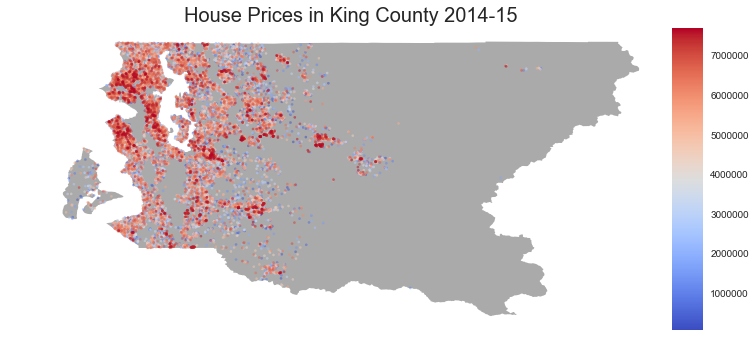

In [8]:
from shapely.geometry import Point
from mpl_toolkits.axes_grid1 import make_axes_locatable

#create coordinate column that geopandas can use
df['Coordinates'] = list(zip(df.long, df.lat))
df['Coordinates'] = df['Coordinates'].apply(Point)

#creating geopandas df with coordinates and prices
geo_price = gpd.GeoDataFrame({'geometry': df['Coordinates'], 'Prices': df.price})

#setting both gpds to same crs attributes
map_df.crs = {'init': 'epsg:4326'}
geo_price.crs = {'init': 'epsg:4326'} 

fig, ax = plt.subplots(1, figsize=(12,15))

#plotting base map and corresponding price points
base = map_df.plot(ax=ax, color='343382')
geo_price.plot(ax=base, cmap = 'coolwarm', marker="o", markersize=5, alpha=0.5)
ax.axis('off')
ax.set_title("House Prices in King County 2014-15", fontsize = 20)

#adding colorbar
smap = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=df.price.min(), vmax=df.price.max()))
smap._A = []
#make colorbar same size as figure
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
#create colorbar
cbar = fig.colorbar(smap, cax= cax)

plt.show()

In [9]:
df.drop(['Coordinates'], axis = 1, inplace = True)
df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [10]:
#Convert date columns to date time datatype
df['date'] = pd.to_datetime(df['date'])
df.date.head()

0   2014-10-13
1   2014-12-09
2   2015-02-25
3   2014-12-09
4   2015-02-18
Name: date, dtype: datetime64[ns]

In [11]:
#Check for unique values in floor. If they seem categorical/integer, then convert accordingly.
df.floors.value_counts() 
#Keep floors as float data type. 

1.0    10673
2.0     8235
1.5     1910
3.0      611
2.5      161
3.5        7
Name: floors, dtype: int64

In [12]:
#Check sqft_basement unique values, since every other sqft column is type casted as integers.
df.sqft_basement.value_counts()
#Found a placeholder value, ? for NaN. Replace possible ? with NaN throughout 
df.replace(to_replace = '?', value = np.nan, inplace = True)
df.sqft_basement.value_counts()

#cannot convert series with NaNs to integer data type, change from str type to float
df.sqft_basement = df.sqft_basement.astype('float')

In [13]:
#Condition, grade, seems categoical, investigate values
#Waterfront and view seem categorical, binary. Convert from float type to boolean?

df.condition.value_counts(dropna = False) #values range from 1-5, least amount in category 1
#ordinal variable

3    14020
4     5677
5     1701
2      170
1       29
Name: condition, dtype: int64

In [14]:
df.grade.value_counts() #values range from 3-13
#Ordinal variable

7     8974
8     6065
9     2615
6     2038
10    1134
11     399
5      242
12      89
4       27
13      13
3        1
Name: grade, dtype: int64

In [15]:
df.waterfront.value_counts(dropna = False) #has 0 and 1 values, could be recasted to boolean 0 = False
#vast majority of King County, WA is inland, so can assume that majority of houses in dataset should not be near waterfront
#however, NaN values would be casted as False with .astype('bool'), which is not always accurate
#plan to bin into True/False/Nan (coarse classification)

 0.0    19075
NaN      2376
 1.0      146
Name: waterfront, dtype: int64

In [16]:
df.view.value_counts(dropna = False)
#Not binary, values from 0-4, also ordinal like grade and condition

#Very few NaNs in view (3)- can likely just drop those rows
df.dropna(subset = ['view'], inplace = True) 

#Note: now there are 21534 total entries in dataframe, not 21537
df.shape

(21534, 20)

In [17]:
#Can convert type to int without NaNs
df.view = df.view.astype('int')
df.view.value_counts()

0    19422
2      957
3      508
1      330
4      317
Name: view, dtype: int64

In [18]:
#Consider binning yr_built.
df.describe() #yr_built has min of 1900, max of 2015. median is 1975. 25% and 75% are 1951 and 1997 respectively
df.yr_built.value_counts()
#No null values in yr_built. Refrain from binning for now- no nulls, discrete variable. No need for coarse classification

2014    558
2006    453
2005    448
2004    430
2003    419
1977    416
2007    415
1978    387
1968    381
2008    366
1967    350
1979    341
1959    333
1990    317
1962    310
2001    304
1954    304
1987    291
1989    289
1969    280
1955    270
1988    269
1999    263
1947    262
1963    254
1976    253
1994    249
1950    249
1966    248
1960    248
       ... 
1909     93
1906     92
1930     89
1919     88
1900     87
1908     86
1923     83
1912     79
1916     79
1921     76
1911     73
1905     73
1937     68
1907     65
1915     64
1931     61
1913     58
1917     55
1914     53
1938     52
1903     46
1904     45
1936     40
1932     38
2015     38
1933     30
1901     29
1902     27
1935     24
1934     21
Name: yr_built, Length: 116, dtype: int64

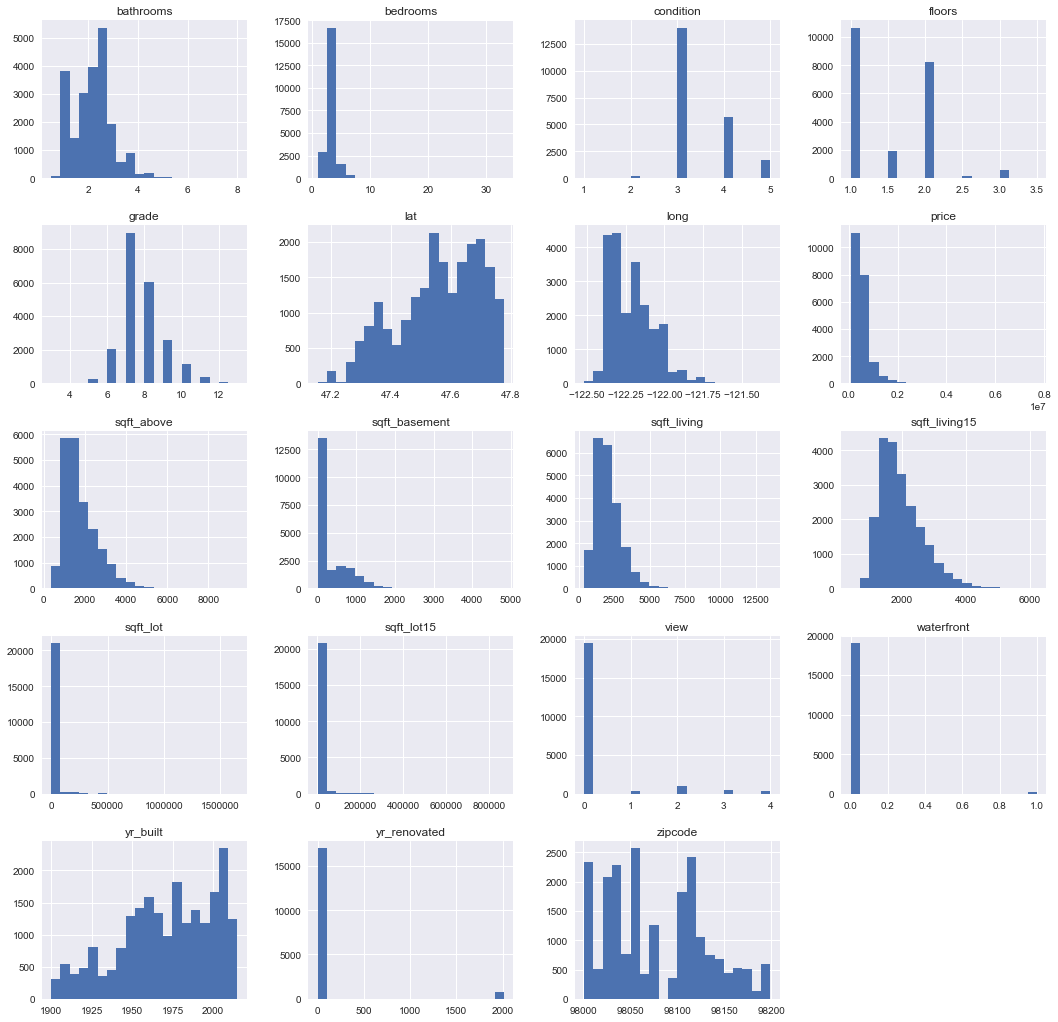

In [19]:
#Last check for numerical vs. categorical variables. Plot histograms

import warnings
warnings.filterwarnings('ignore') #ignore warning message

fig = plt.figure(figsize=(18,18))
ax = fig.gca()
df.hist(ax=ax, bins = 20)
plt.show()

#numerical variables are mostly positively skewed, with the exception of zipcode, yr_built, and lat
#lat is negatively skewed
#grade seems to have a normal distribution

## Check for Multicollinarity before binning and one-hot encoding
* Plan to bin yr_renovated, waterfront
    * Coarse classification for yr_renovated, waterfront
* One-hot encoding for condition, grade, view

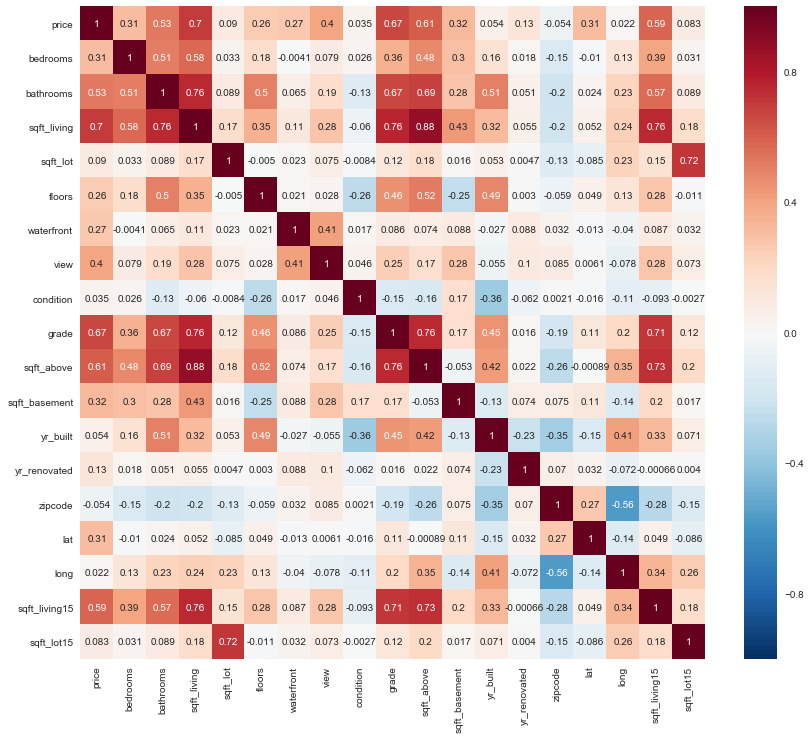

In [20]:
#create heatmap to drop correlated values, especially sqft variables
correlation = df.corr()
plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(correlation, annot=True, linewidths=0, vmin=-1, cmap="RdBu_r")

#Price seems highly correlated with sqft_living, grade
#Sqft_living highly correlated with sqft_living15, sqft_above, bathrooms, grade
#sqft_lot correlated with sqft_lot15
#Drop: sqft_living15, sqft_lot15, sqft_above

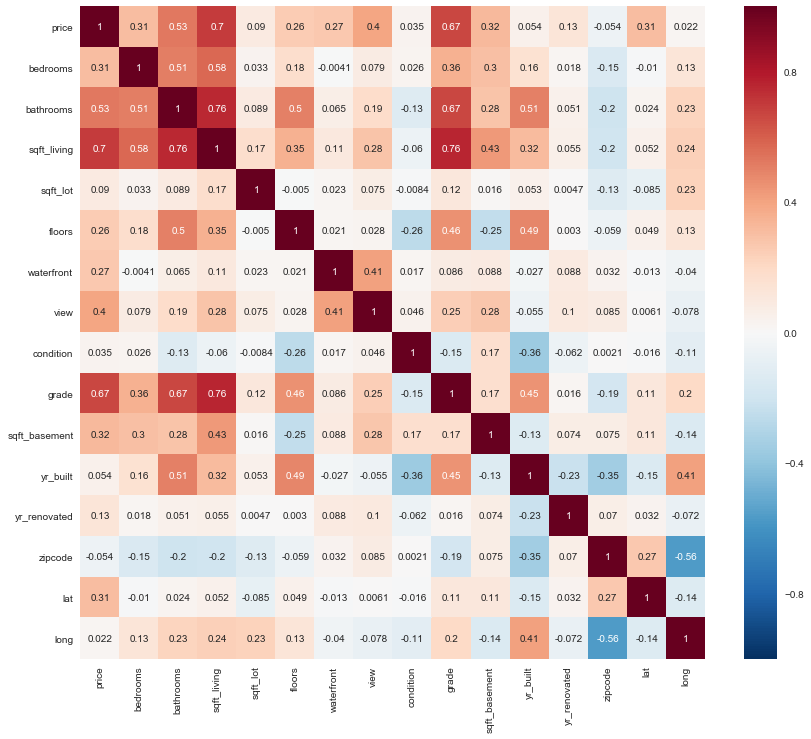

In [21]:
dropped_df[['sqft_living15', 'sqft_lot15', 'sqft_above']] = df[['sqft_living15', 'sqft_lot15', 'sqft_above']]
df = df.drop(['sqft_living15', 'sqft_lot15', 'sqft_above'], axis = 1)

#Check heatmap after dropping columns
correlation = df.corr()
plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(correlation, annot=True, linewidths=0, vmin=-1, cmap="RdBu_r")
#sqft_living is correlated with bathrooms and grade
#But r-squared (0.76) is not as high as the correlation between sqft_above and sqft_living (0.88)
#Therefore, we will keep sqft_living. It has the highest r-squared (0.7) when compared to bathrooms (0.53) and grade (0.67)


## Check for Linearity 
* Check for linearity with scatter plots

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21534 entries, 0 to 21596
Data columns (total 17 columns):
date             21534 non-null datetime64[ns]
price            21534 non-null float64
bedrooms         21534 non-null int64
bathrooms        21534 non-null float64
sqft_living      21534 non-null int64
sqft_lot         21534 non-null int64
floors           21534 non-null float64
waterfront       19164 non-null float64
view             21534 non-null int32
condition        21534 non-null int64
grade            21534 non-null int64
sqft_basement    21082 non-null float64
yr_built         21534 non-null int64
yr_renovated     17704 non-null float64
zipcode          21534 non-null int64
lat              21534 non-null float64
long             21534 non-null float64
dtypes: datetime64[ns](1), float64(8), int32(1), int64(7)
memory usage: 3.5 MB


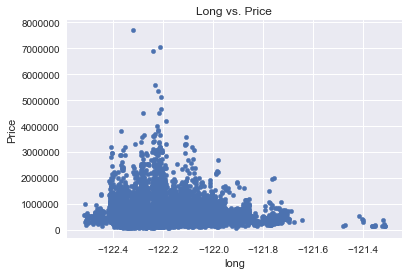

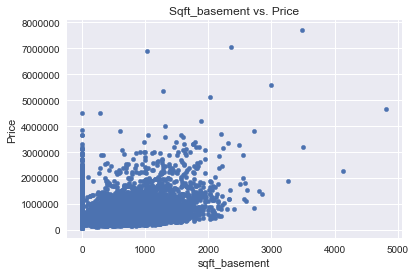

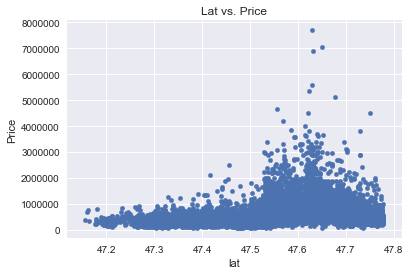

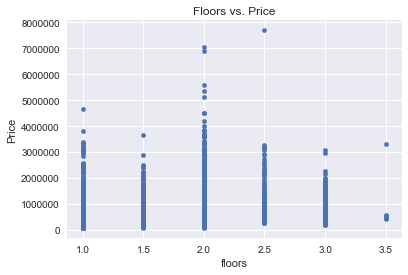

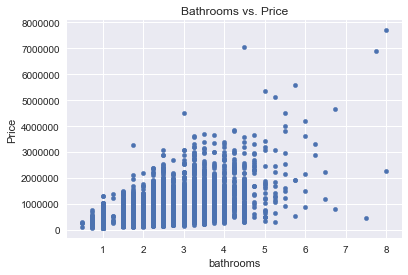

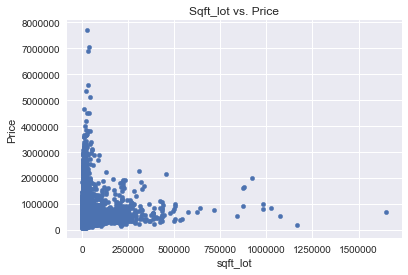

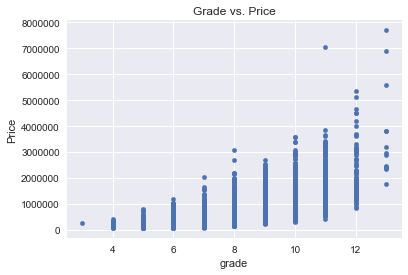

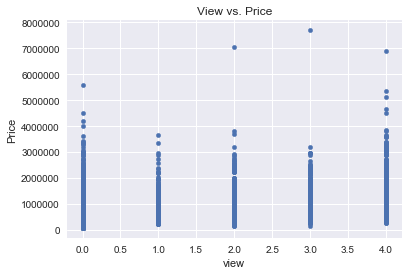

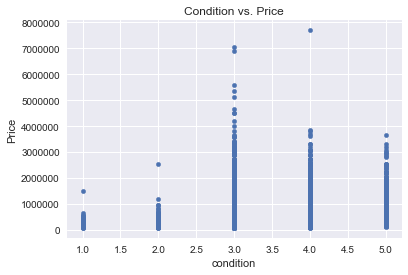

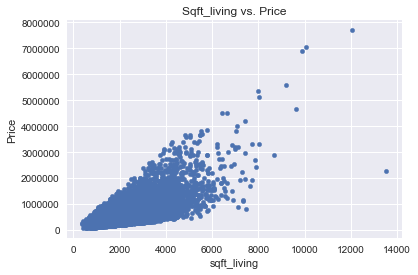

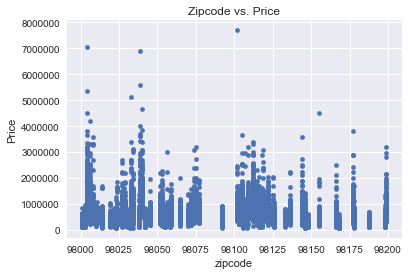

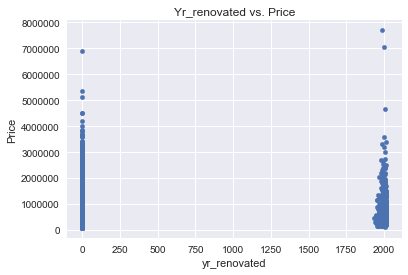

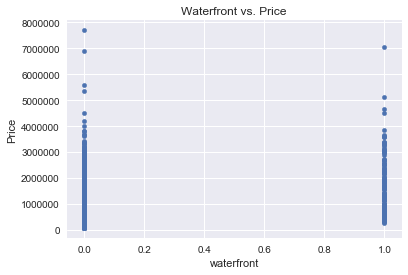

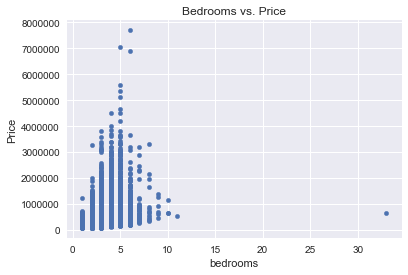

In [23]:
col_lst = list(df.columns)
col_lst = set(col_lst) - {'price', 'date', 'yr_built'}
for col in col_lst:
    df.plot.scatter(x = col, y = 'price')
    plt.title(col.capitalize() + ' vs. Price')
    plt.ylabel('Price')
    plt.show()

From a cursory glance at the scatter plots of the numerical variables, it seems that sqft_living, bathrooms, bedrooms, sqft_basement, grade, and condition may have a positive linear correlation with house price. The relationship is unclear with view, floors, zipcode, long, lat, and sqft_lot.

Yr_renovated seems like it should be binned into two categories for analysis. It is difficult to determine a relationship with price when looking at categorical variables like yr_renovated or waterfront.

The scatter plots of variables seem to indicate that there are outliers in the data. The bedrooms variable very clearly has an outlier. We'll have to deal with these outliers before modelling. But first, we will deal with the categorical variables, nulls, and normalization.

## Handling Nulls
* Coarse Classification for Nulls
    * Bin yr_renovated, waterfront
* How to handle sqft_basement? From the scatter plot, it doesn't seem like it can be binned very easily. Furthermore, there seemed to be a positive linear relationship between sqft_basement and price. It might be best to drop the rows with nulls instead for this variable.

In [24]:
df.isna().sum(0)

date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2370
view                0
condition           0
grade               0
sqft_basement     452
yr_built            0
yr_renovated     3830
zipcode             0
lat                 0
long                0
dtype: int64

In [25]:
df.yr_renovated.value_counts(dropna = False).sort_index() #Do 0.0 need to be converted to NaNs (16861 0.0 and 3830 NaN)
#There is the possibility that 0.0 means something different from Nan (ex. 0.0 = never renovated vs. NaN = unknown)
#Bin houses in the 0.0 category 

 0.0       16961
 1934.0        1
 1940.0        2
 1944.0        1
 1945.0        3
 1946.0        1
 1948.0        1
 1950.0        1
 1951.0        1
 1953.0        1
 1954.0        1
 1955.0        3
 1956.0        3
 1957.0        2
 1958.0        3
 1959.0        1
 1960.0        3
 1962.0        2
 1963.0        4
 1964.0        5
 1965.0        4
 1967.0        2
 1968.0        7
 1969.0        4
 1970.0        9
 1971.0        1
 1972.0        3
 1973.0        4
 1974.0        2
 1975.0        5
           ...  
 1987.0       14
 1988.0       11
 1989.0       20
 1990.0       22
 1991.0       16
 1992.0       13
 1993.0       12
 1994.0       14
 1995.0       11
 1996.0       11
 1997.0       12
 1998.0       16
 1999.0       15
 2000.0       29
 2001.0       15
 2002.0       17
 2003.0       31
 2004.0       22
 2005.0       29
 2006.0       20
 2007.0       30
 2008.0       15
 2009.0       21
 2010.0       15
 2011.0        9
 2012.0        8
 2013.0       31
 2014.0       

In [26]:
df.sqft_basement.value_counts().sort_index()

0.0       12798
10.0          2
20.0          1
40.0          4
50.0         11
60.0         10
65.0          1
70.0          6
80.0         20
90.0         21
100.0        42
110.0        18
120.0        53
130.0        25
140.0        53
143.0         1
145.0         5
150.0        44
160.0        29
170.0        28
172.0         1
176.0         1
180.0        38
190.0        33
200.0       105
207.0         1
210.0        26
220.0        43
225.0         1
230.0        11
          ...  
2170.0        3
2190.0        1
2196.0        1
2200.0        2
2220.0        3
2240.0        1
2250.0        1
2300.0        1
2310.0        1
2330.0        2
2350.0        1
2360.0        1
2400.0        1
2490.0        1
2500.0        1
2550.0        2
2570.0        1
2580.0        1
2600.0        1
2610.0        1
2720.0        1
2730.0        1
2810.0        1
2850.0        1
3000.0        1
3260.0        1
3480.0        1
3500.0        1
4130.0        1
4820.0        1
Name: sqft_basement, Len

In [27]:
#Binning: Create separate bin for NaNs in yr_renovated, waterfront

df.waterfront.describe()
#Waterfront bins: 0, 1, NaNs
#df.waterfront = df.waterfront.astype('float')
bins = [0.0, 0.9, 1.1] 
labels = ['0', '1']
df['waterfront_bins'] = pd.cut(df['waterfront'], bins=bins, labels=labels, include_lowest=True)
df.head()

df.waterfront_bins.replace(np.nan, "NaN", inplace = True, regex = True)
df.waterfront_bins.value_counts()

0      19019
NaN     2370
1        145
Name: waterfront_bins, dtype: int64

In [28]:
df.yr_renovated.value_counts(dropna = False).sort_index()
#yr_renovated bins: 0.0, NaNs, 2015 max, 1934 min (from sorting index on value counts)

#Create three bins: one for 0.0, one for NaNs, last one for renovated = yes
#Labels will be NaN, 0, and 1, respectively

bins = [0.0, 1933, 2016]
labels = ['0', '1']
df['yr_renovated_bins'] = pd.cut(df['yr_renovated'], bins=bins, labels=labels, include_lowest = True)

df.yr_renovated_bins.value_counts(dropna = False)

0      16961
NaN     3830
1        743
Name: yr_renovated_bins, dtype: int64

In [29]:
df.yr_renovated_bins.replace(np.nan, "NaN", inplace = True, regex = True)
#df.yr_renovated_bins.value_counts()

In [30]:
#Can we drop the nulls in sqft_basement?
#Check percentage of nulls
df.sqft_basement.isna().sum()/df.shape[0]

#2.1% nulls. Dropping these data points should have a fairly minimal effect 
df.shape[0] - df.sqft_basement.isna().sum() #should have 21082 data points left after dropping these nulls
df.dropna(subset = ['sqft_basement'], inplace = True)
df.shape[0] #21082! Dropped nulls correctly

21082

In [31]:
df.head()
#drop waterfront, yr_renovated
scrub_df = df.drop(['waterfront','yr_renovated'], axis = 1)
scrub_df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_basement,yr_built,zipcode,lat,long,waterfront_bins,yr_renovated_bins
0,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,3,7,0.0,1955,98178,47.5112,-122.257,NaN,0
1,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,3,7,400.0,1951,98125,47.7210,-122.319,0,1
2,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,3,6,0.0,1933,98028,47.7379,-122.233,0,NaN
3,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,5,7,910.0,1965,98136,47.5208,-122.393,0,0
4,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,3,8,0.0,1987,98074,47.6168,-122.045,0,0


In [32]:
scrub_df.isna().sum()

date                 0
price                0
bedrooms             0
bathrooms            0
sqft_living          0
sqft_lot             0
floors               0
view                 0
condition            0
grade                0
sqft_basement        0
yr_built             0
zipcode              0
lat                  0
long                 0
waterfront_bins      0
yr_renovated_bins    0
dtype: int64

We're all set with nulls! Time to normalize the data.

## Normalizing Data
* Check normality with qqplots
* Normalize int and float columns
    * Will not normalize zipcode, as it is technically categorical 
    * Leave yr_built and date as datetime 
    * Normalization will include: price, bedrooms, bathrooms, sqft_lot, floors, sqft_basement
    * Waterfront and yr_renovated are categories now
    * Condition and grade will be one-hot encoded as categorical

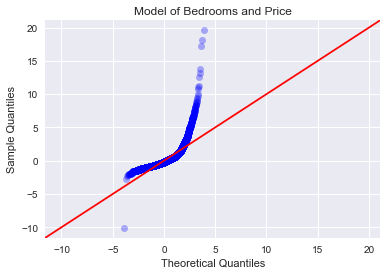

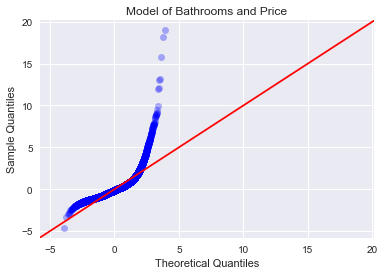

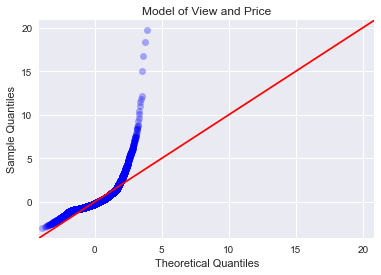

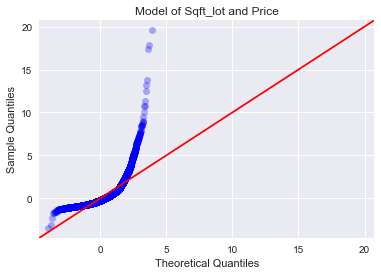

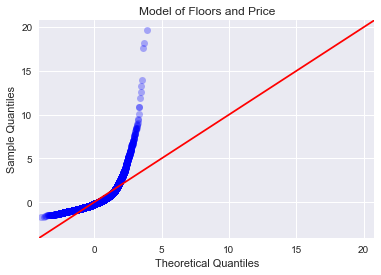

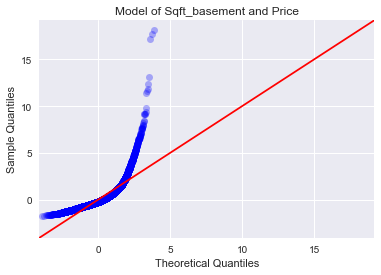

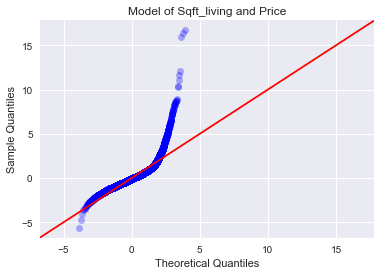

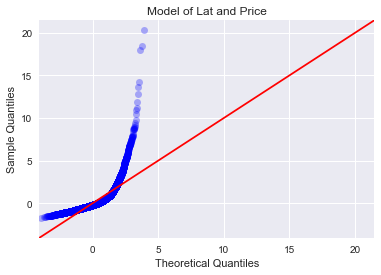

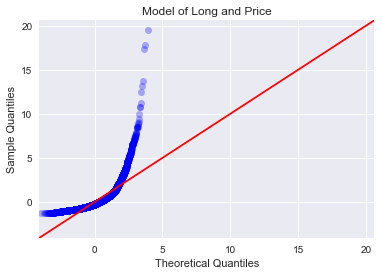

In [33]:
#Create for loop which pairs one numerical variable with price to create multiple formulas. 
#Find residuals for each model created and plot respective qqplot

for col in ['bedrooms', 'bathrooms', 'view', 'sqft_lot', 'floors', 'sqft_basement', 'sqft_living', 'lat', 'long']:
    f = 'price~' + col
    model = ols(formula = f, data = df).fit()
    residuals = model.resid
    fig = sm.graphics.qqplot(residuals, dist = stats.norm, line = '45', fit = True, alpha = 0.3)
    plt.title('Model of '+ col.capitalize() + ' and Price')
    fig.show()

From the qqplots of the original data, we can see there are gaps in values for all of these numerical variables. Furthermore, they are certainly not normally distributed, and will need some normalization, as suspected from looking at the histograms.

In [34]:
#Use scrub_df for normalized values
#Using a copy of df to preserve original df information before log transformation
df1 = df
df1.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_basement',
       'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'waterfront_bins',
       'yr_renovated_bins'],
      dtype='object')

In [35]:
scrub_df.info()
scrub_df.max() #Check for inf values before log transform
scrub_df.isna().sum() #Check for nulls before log transform

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21082 entries, 0 to 21596
Data columns (total 17 columns):
date                 21082 non-null datetime64[ns]
price                21082 non-null float64
bedrooms             21082 non-null int64
bathrooms            21082 non-null float64
sqft_living          21082 non-null int64
sqft_lot             21082 non-null int64
floors               21082 non-null float64
view                 21082 non-null int32
condition            21082 non-null int64
grade                21082 non-null int64
sqft_basement        21082 non-null float64
yr_built             21082 non-null int64
zipcode              21082 non-null int64
lat                  21082 non-null float64
long                 21082 non-null float64
waterfront_bins      21082 non-null object
yr_renovated_bins    21082 non-null object
dtypes: datetime64[ns](1), float64(6), int32(1), int64(7), object(2)
memory usage: 2.8+ MB


date                 0
price                0
bedrooms             0
bathrooms            0
sqft_living          0
sqft_lot             0
floors               0
view                 0
condition            0
grade                0
sqft_basement        0
yr_built             0
zipcode              0
lat                  0
long                 0
waterfront_bins      0
yr_renovated_bins    0
dtype: int64

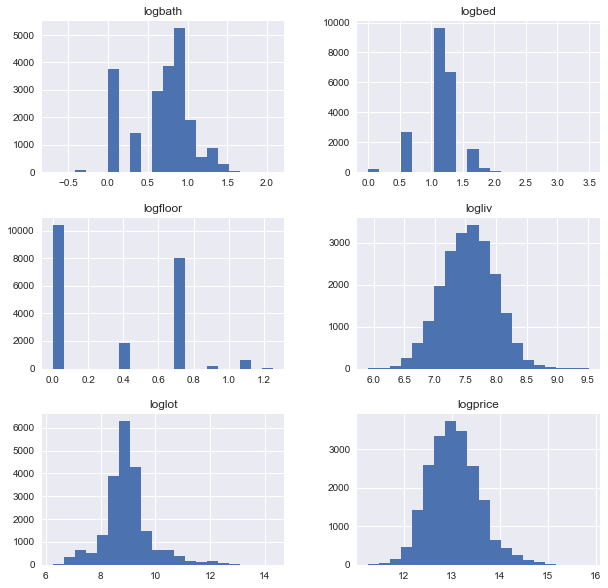

In [36]:
#log transform if positively skewed: bathrooms, bedrooms, floors, price, sqft_lot, sqft_living
#log transform negatively skewed lat as well
#Will need to transform sqft_basement, view, long differently. Log of 0 or negative numbers is undefined. 

data_log = pd.DataFrame([])
data_log['logbath'] = np.log(scrub_df['bathrooms'])
data_log['logbed'] = np.log(scrub_df['bedrooms'])
data_log['logfloor'] = np.log(scrub_df['floors'])
data_log['logprice'] = np.log(scrub_df['price'])
data_log['loglot'] = np.log(scrub_df['sqft_lot'])
data_log['logliv'] = np.log(scrub_df['sqft_living'])

warnings.filterwarnings('ignore')

fig = plt.figure(figsize = (10,10))
ax = fig.gca()
data_log.hist(ax=ax, bins = 20)
plt.show()

The log transformed variables seem much more normally distributed now. The exception is floors. When comparing the log distribution to the original data distribution, there was not much change. 

In [37]:
#Normalization will include: price, bedrooms, bathrooms, sqft_lot, floors, sqft_living
#Min-max scaling will include: sqft_basement, long
#Decided not to use standardization with sqft_basement or view because there is a preponderance of 0's, which will skew the mean
#Furthermore, ln(0) is neg infinity
#Cannot standardize long for similar reasons - ln(negative numbers) = neg infinity
#Will min/max transform lat, to keep consistency with long
#Log transform did not help normalize floors, use original variable from scrub_df
#Distribution of view is not improved with min/max or standardization, leave as is

price = data_log.logprice
bed = data_log.logbed
bath = data_log.logbath
lot = data_log.loglot
liv = data_log.logliv
floor = scrub_df.floors
base = scrub_df.sqft_basement
long = scrub_df.long
lat = scrub_df.lat

scrub_df.price = (price-np.mean(price))/np.sqrt(np.var(price))
scrub_df.bedrooms = (bed-np.mean(bed))/np.sqrt(np.var(bed))
scrub_df.bathrooms = (bath-np.mean(bath))/np.sqrt(np.var(bath))
scrub_df.sqft_lot = (lot-np.mean(lot))/np.sqrt(np.var(lot))
scrub_df.sqft_living = (liv-np.mean(liv))/np.sqrt(np.var(liv))
scrub_df.floors = (floor-np.mean(floor))/np.sqrt(np.var(floor))
scrub_df.sqft_basement = (base-min(base))/(max(base)-min(base))
scrub_df.long = (long-min(long))/(max(long)-min(long))
scrub_df.lat = (lat-min(lat))/(max(lat)-min(lat))

In [38]:
scrub_df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_basement,yr_built,zipcode,lat,long,waterfront_bins,yr_renovated_bins
0,2014-10-13,-1.402472,-0.279822,-1.728609,-1.126365,-0.389678,-0.915200,0,3,7,0.000000,1955,98178,0.571498,0.217608,NaN,0
1,2014-12-09,0.280020,-0.279822,0.339516,0.709592,-0.114279,0.938857,0,3,7,0.082988,1951,98125,0.908959,0.166113,0,1
2,2015-02-25,-1.800035,-1.714195,-1.728609,-2.133226,0.243709,-0.915200,0,3,6,0.000000,1933,98028,0.936143,0.237542,0,NaN
3,2014-12-09,0.499852,0.737882,1.073196,0.070488,-0.525265,-0.915200,0,5,7,0.188797,1965,98136,0.586939,0.104651,0,0
4,2015-02-18,0.178481,-0.279822,0.039133,-0.293101,0.007193,-0.915200,0,3,8,0.000000,1987,98074,0.741354,0.393688,0,0


## One-hot Encoding 
* For categorical variables condition, grade
* Also one-hot enocode the binned variables earlier

In [39]:
#One-hot encoding for condition, grade

cond_dummies = pd.get_dummies(scrub_df.condition, prefix='cond')
grade_dummies = pd.get_dummies(scrub_df.grade, prefix='grade')
water_dummies = pd.get_dummies(scrub_df.waterfront_bins, prefix = 'water')
yr_renov_dummies = pd.get_dummies(scrub_df.yr_renovated_bins, prefix='yr_renov')

scrub_df = pd.concat([scrub_df, cond_dummies, grade_dummies, water_dummies, yr_renov_dummies], axis = 1)

#Dropped_df to hold dropped variables which are not in df
#Adding waterfront_bins and yr_renovated_bins to dropped_df
dropped_df = pd.concat([dropped_df, scrub_df.iloc[:,15:17]], axis = 1)
scrub_df.drop(['condition','grade', 'waterfront_bins', 'yr_renovated_bins'], axis = 1, inplace = True)
scrub_df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,sqft_basement,yr_built,...,grade_10,grade_11,grade_12,grade_13,water_0,water_1,water_NaN,yr_renov_0,yr_renov_1,yr_renov_NaN
0,2014-10-13,-1.402472,-0.279822,-1.728609,-1.126365,-0.389678,-0.915200,0,0.000000,1955,...,0,0,0,0,0,0,1,1,0,0
1,2014-12-09,0.280020,-0.279822,0.339516,0.709592,-0.114279,0.938857,0,0.082988,1951,...,0,0,0,0,1,0,0,0,1,0
2,2015-02-25,-1.800035,-1.714195,-1.728609,-2.133226,0.243709,-0.915200,0,0.000000,1933,...,0,0,0,0,1,0,0,0,0,1
3,2014-12-09,0.499852,0.737882,1.073196,0.070488,-0.525265,-0.915200,0,0.188797,1965,...,0,0,0,0,1,0,0,1,0,0
4,2015-02-18,0.178481,-0.279822,0.039133,-0.293101,0.007193,-0.915200,0,0.000000,1987,...,0,0,0,0,1,0,0,1,0,0


## Check for Outliers
* Check for outliers with box plots 
* Decide whether or not to drop outliers

In [40]:
scrub_df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'view', 'sqft_basement', 'yr_built', 'zipcode', 'lat', 'long',
       'cond_1', 'cond_2', 'cond_3', 'cond_4', 'cond_5', 'grade_3', 'grade_4',
       'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9', 'grade_10',
       'grade_11', 'grade_12', 'grade_13', 'water_0', 'water_1', 'water_NaN',
       'yr_renov_0', 'yr_renov_1', 'yr_renov_NaN'],
      dtype='object')

In [41]:
col_lst = col_lst - {'waterfront', 'condition','grade','yr_renovated','zipcode'}
col_lst

{'bathrooms',
 'bedrooms',
 'floors',
 'lat',
 'long',
 'sqft_basement',
 'sqft_living',
 'sqft_lot',
 'view'}

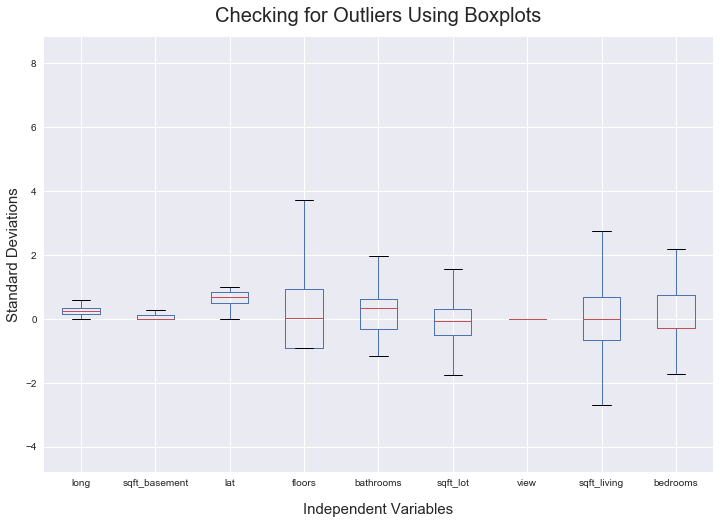

In [42]:
#for col in col_lst:
fig = plt.figure(figsize = (12,8))
scrub_df.boxplot(column = list(col_lst))
plt.xlabel('Independent Variables', fontsize = 15, labelpad = 15)
plt.ylabel('Standard Deviations', fontsize = 15)
plt.title('Checking for Outliers Using Boxplots', fontsize = 20, pad = 15)
    #plt.title(col.capitalize() + ' vs. Price')
    #plt.ylabel('Price')
plt.show()

From analysis of the boxplots, it seems that the floors variable is the only predictor with a standard deviation over |3|. However, these outliers might be meaningful. Furthermore, keeping them will likely have limited effect on modelling since we have quite a large dataset. 

Check the entries that correspond with the outliers.

In [43]:
df.floors.value_counts()

1.0    10427
2.0     8043
1.5     1858
3.0      593
2.5      154
3.5        7
Name: floors, dtype: int64

In [44]:
df.loc[df.floors == 3.5]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,waterfront_bins,yr_renovated_bins
10066,2014-08-01,435000.0,3,3.00,1440,1350,3.5,0.0,2,3,8,0.0,2005,0.0,98103,47.6525,-122.345,0,0
11582,2015-01-30,544000.0,3,2.50,1760,1755,3.5,0.0,0,3,8,0.0,1998,0.0,98105,47.6688,-122.279,0,0
14871,2015-04-02,525000.0,3,3.00,1730,1074,3.5,0.0,0,3,8,0.0,2006,0.0,98107,47.6692,-122.392,0,0
15410,2015-04-16,479000.0,2,2.50,1730,1037,3.5,0.0,0,3,8,0.0,2008,0.0,98118,47.5594,-122.285,0,0
18462,2014-10-20,3300000.0,8,4.00,7710,11750,3.5,0.0,0,5,12,1620.0,1904,0.0,98112,47.6263,-122.314,0,0
20292,2014-09-18,525000.0,2,2.75,1310,1268,3.5,0.0,0,3,8,0.0,2007,0.0,98103,47.6534,-122.355,0,0
20756,2014-06-25,563500.0,3,2.50,1400,1312,3.5,NaN,0,3,8,0.0,2007,NaN,98103,47.6534,-122.355,NaN,NaN


Upon examining the data, these outliers don't seem to be nonsense entries. It may be more beneficial to keep them. The house with 8 bedrooms, 4 bathrooms, with an extensive lot and basement sold for 3.3 million dollars. Although the price and grade are fairly unusual in this dataset, it is not an unusual price for houses in that zipcode, 98112, which is near Seattle.
Most houses are selling for 1-5 million dollars in this region (per Zillow).

## Create separate dataframes 
One for categorical variables, one for floats and integers, one for place and time. Helps keep things organized.

Set up y variable as target, 'price', in preparation for regression analysis.

In [45]:
#Checking columns
scrub_df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'view', 'sqft_basement', 'yr_built', 'zipcode', 'lat', 'long',
       'cond_1', 'cond_2', 'cond_3', 'cond_4', 'cond_5', 'grade_3', 'grade_4',
       'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9', 'grade_10',
       'grade_11', 'grade_12', 'grade_13', 'water_0', 'water_1', 'water_NaN',
       'yr_renov_0', 'yr_renov_1', 'yr_renov_NaN'],
      dtype='object')

In [46]:
cat_df = pd.concat([scrub_df.iloc[:,13:39]], axis =1)
cat_df.head()

,cond_1,cond_2,cond_3,cond_4,cond_5,grade_3,grade_4,grade_5,grade_6,grade_7,...,grade_10,grade_11,grade_12,grade_13,water_0,water_1,water_NaN,yr_renov_0,yr_renov_1,yr_renov_NaN
0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,1,0,0
1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
2,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
3,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [47]:
num_df = pd.concat([scrub_df.iloc[:,2:9]], axis = 1)
num_df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,sqft_basement
0,-0.279822,-1.728609,-1.126365,-0.389678,-0.915200,0,0.000000
1,-0.279822,0.339516,0.709592,-0.114279,0.938857,0,0.082988
2,-1.714195,-1.728609,-2.133226,0.243709,-0.915200,0,0.000000
3,0.737882,1.073196,0.070488,-0.525265,-0.915200,0,0.188797
4,-0.279822,0.039133,-0.293101,0.007193,-0.915200,0,0.000000


In [48]:
timeplace_df = pd.concat([scrub_df.iloc[:,0:1], scrub_df.iloc[:,9:13]], axis = 1)
timeplace_df.head()

,date,yr_built,zipcode,lat,long
0,2014-10-13,1955,98178,0.571498,0.217608
1,2014-12-09,1951,98125,0.908959,0.166113
2,2015-02-25,1933,98028,0.936143,0.237542
3,2014-12-09,1965,98136,0.586939,0.104651
4,2015-02-18,1987,98074,0.741354,0.393688


In [49]:
#Lowercase y will be log transformed, standardized price column
#Uppercase Y will be original price column
y = scrub_df['price']
Y = df['price']

## Last Check before Modelling
* KDE and histograms
* qqplots

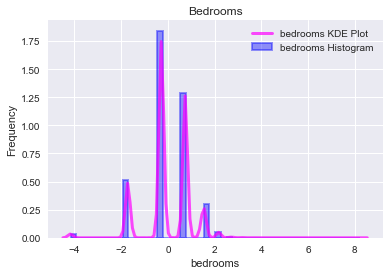

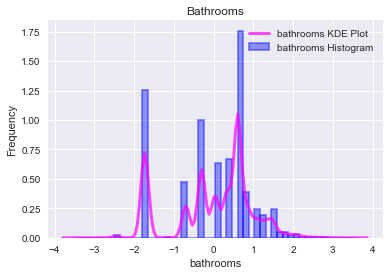

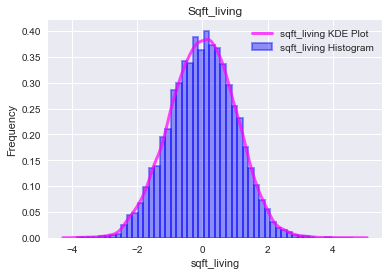

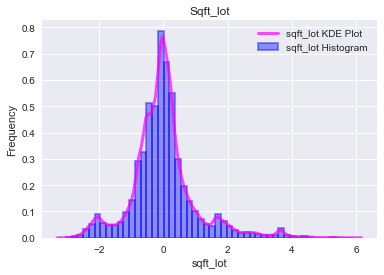

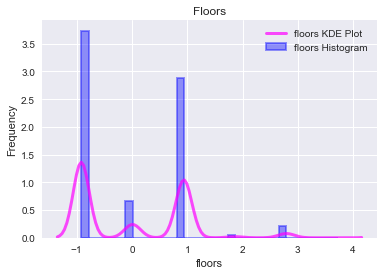

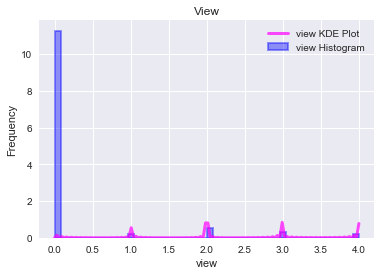

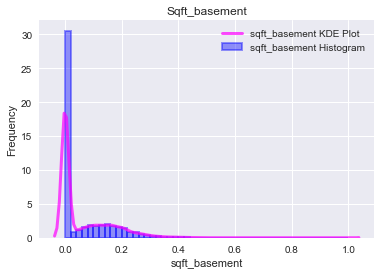

In [50]:
#kde and histograms of num variables
#Using kde, which is non-parametric way of visualizing underlying distribution (probability density function)
#Allows for more detailed information on distribution as compared to the histogram, which is more discrete.
#Helps better answer the question: Is the data normally distributed?
for col in list(num_df.columns):
    sns.distplot(num_df[col], 
                 hist=True, hist_kws={
                                      "linewidth": 2,
                                      'facecolor': 'b',
                                      "edgecolor" :'b',
                                      "alpha": 0.4, 
                                      "color":  "w",
                                      "label": col + " Histogram",
                                      },
                 kde=True, kde_kws = {'linewidth': 3,
                                      'color': "magenta",
                                      "alpha": 0.7,
                                      'label':col + ' KDE Plot'
                                     })

    plt.title(col.capitalize())
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
#Need some help plotting these hist/kdes in a 2x3 array

In [51]:
list(num_df.columns).extend(list(timeplace_df.iloc[:,3:5].columns))

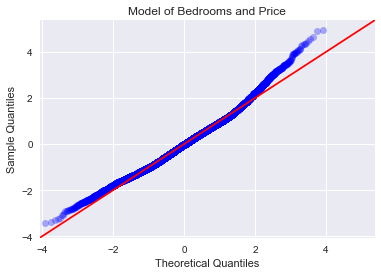

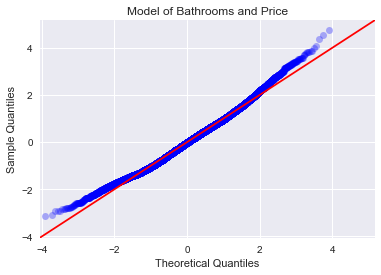

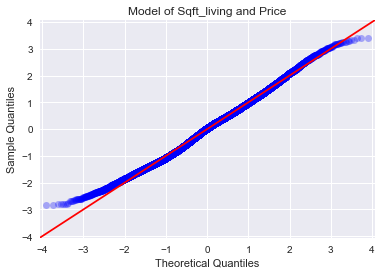

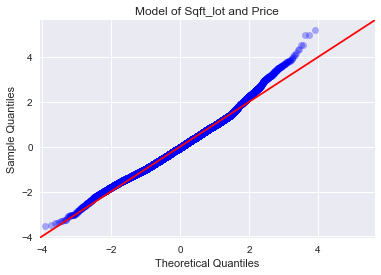

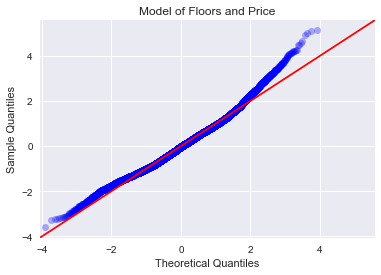

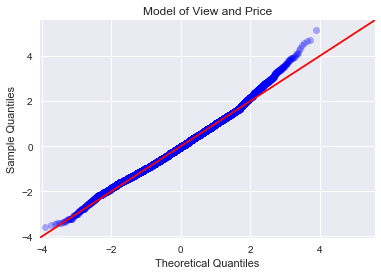

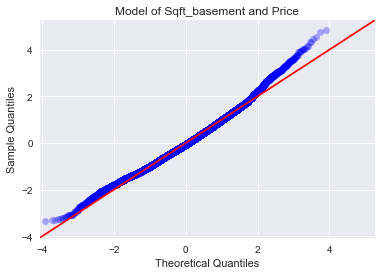

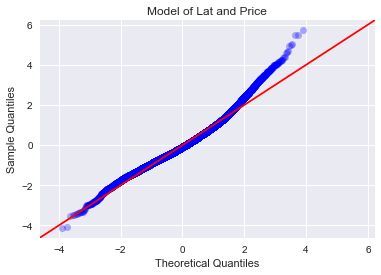

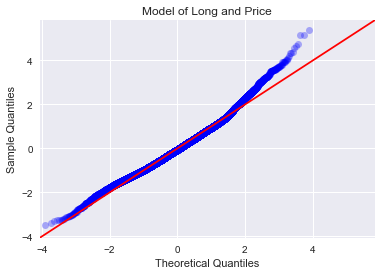

In [52]:
#Plotting variables which have been log transformed and standardized to check for improvement in distribution
check_df = pd.concat((num_df, timeplace_df.iloc[:,3:5], y.rename('Price')), axis = 1)
check_df.head()

lst = list(num_df.columns)
lst.extend(list(timeplace_df.iloc[:,3:5].columns))
for col in lst:
    f = 'price~' + col
    model = ols(formula = f, data = check_df).fit()
    residuals = model.resid
    fig = sm.graphics.qqplot(residuals, dist = stats.norm, line = '45', fit = True, alpha = 0.3)
    plt.title('Model of '+ col.capitalize() + ' and Price')
    fig.show()

The numerical variables which were log transformed and standardized (or just min-max scaled in the case of sqft_basement, lat and long) seem much more normal than before. We are ready for modelling!

## Questions to Investigate
Overall question for regression: Which variables should be used to form a model which best predicts price?

1. Do more recent renovations improve housing price?
2. Are houses with the same number of grade more expensive when sold recently vs. a long time ago? 
3. Is there a significant difference in price depending on number of bathrooms?

Reasoning for question 1: 
Would like to investigate a categorical variable, especially after data cleaning and scrubbing, to see if it now shows any correlation with price. The initial correlation heatmap showed very little correlation between yr_renovated and price. From a business perspective, it would be helpful to know whether an investment of renovation would increase house price or not, in order to predict when to renovate a house. Would last minute renovations before selling improve price?

Reasoning for question 2: 
Investigating a numerical variable. If the answer to this question is yes and high correlation is found between recent purchases and price, then it might help a company better decide when to invest in flipping houses and when to invest in multiple properties to for appreciation in house value. Using grade as a control when comparing, since it seems to be moderately correlated with price upon checking the correlation heatmap.
* Depending on how data was collected, price may be price of house when last sold, rather than current price. Usually governments keep track of house value for for taxing purposes, but cannot be certain that these prices reflect current value. 

Reasoning for question 3: 
Bathrooms was moderately correlated with price on heatmap. Answering this question could help businesses decide whether renovating a house by adding a bathroom might allow them to sell it for more. 


## Question 1: Do more recent renovations improve housing price?

In [53]:
for col in ('yr_renov_0', 'yr_renov_1', 'yr_renov_NaN'):
    print(cat_df[col].value_counts())

1    16618
0     4464
Name: yr_renov_0, dtype: int64
0    20360
1      722
Name: yr_renov_1, dtype: int64
0    17340
1     3742
Name: yr_renov_NaN, dtype: int64


In [54]:
q1_df = pd.concat([dropped_df.yr_renovated_bins, Y], axis = 1)
q1_df.head()

,yr_renovated_bins,price
0,0,221900.0
1,1,538000.0
2,NaN,180000.0
3,0,604000.0
4,0,510000.0


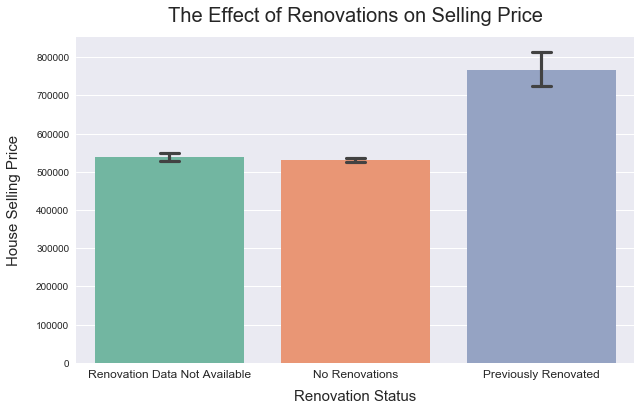

In [55]:
#Using sns to explore their visualizations. 
#Had much less exposure to sns visualizations compared to matplotlib over the first module
ax = plt.figure(figsize = (10,6))
ax = sns.barplot(x = 'yr_renovated_bins', y = 'price', data = q1_df, order = ['NaN', '0', '1'], capsize=.1, palette = "Set2")
ax.set_ylabel('House Selling Price', fontsize = 15, labelpad = 15)
ax.set_xticklabels(('Renovation Data Not Available', 'No Renovations', 'Previously Renovated'), fontsize = 12)
ax.set_xlabel('Renovation Status', fontsize = 15, labelpad = 10)
ax.set_title('The Effect of Renovations on Selling Price', fontsize = 20, pad = 15)
plt.show()

In [56]:
q1_df.groupby('yr_renovated_bins').mean()

,price
yr_renovated_bins,
0,530776.863521
1,767198.986150
NaN,538513.457777


In [57]:
model = ols(formula='price ~ yr_renovated_bins', data=q1_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     289.6
Date:                Wed, 27 Mar 2019   Prob (F-statistic):           2.00e-64
Time:                        15:50:04   Log-Likelihood:            -2.4671e+05
No. Observations:               17340   AIC:                         4.934e+05
Df Residuals:                   17338   BIC:                         4.934e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               5.308e+05   2834.753    187.239      0.000    5.25e+05    5.36e+05
yr_renovated_bins[T.1]  2.364e+05   1.39e+04     17.018      0.000    2.09e+05    2.64e+05
==============================================================================
Omnibus:                    15447.512   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           958095.555
Skew:                           4.049   Prob(JB):                         0.00
Kurtosis:                      38.504   Cond. No.                         5.02
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

I decided to compare bins vs. the original data for housing price, before it was normalized, as it is difficult to understand the scale when using the normalized variable. The NaN and Not Renovated categories are fairly similar, with comparatively minimal 95% confidence interval and a mean around $550,000. 

` The average housing price is approximately $538,513, $530,776, and $767,198, for the categories of missing, no renovations, and past renovations, respectively. `

It does seem that renovations improve housing price, as we can see a massive increase in selling price (200k+) when comparing houses which were not renovated previously, or have unknown renovation status, with houses which were previously renovated.

The data seems to support the idea that renovations improve housing price. Furthermore, lack of data on renovations does not improve house price. Therefore, if a house has been previously renovated, this information should be researched, recorded, and presented to buyers when you aim to sell a house for more money. I would recommend sellers spend time researching their houses' previous renovations in order to improve their selling price.

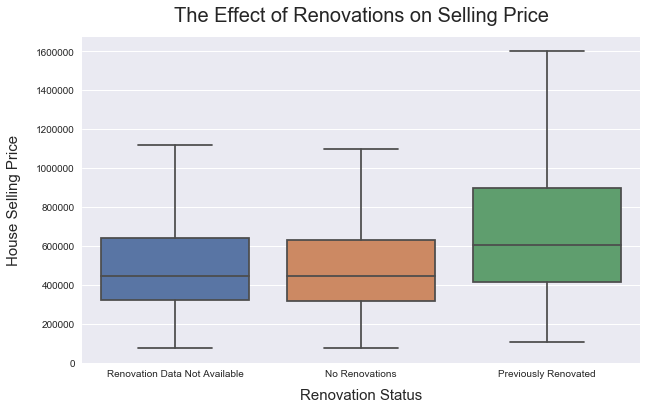

In [58]:
ax = plt.figure(figsize = (10,6))
ax = sns.boxplot(x = 'yr_renovated_bins', y = 'price', data = q1_df, order = ['NaN', '0', '1'], palette = 'deep', showfliers = False)
ax.set_ylabel('House Selling Price', fontsize = 15, labelpad = 15)
ax.set_xticklabels(('Renovation Data Not Available', 'No Renovations', 'Previously Renovated'))
ax.set_xlabel('Renovation Status', fontsize = 15, labelpad = 10)
ax.set_title('The Effect of Renovations on Selling Price', fontsize = 20, pad = 15)
plt.show()

In [59]:
q1_df.groupby('yr_renovated_bins').describe()

price                                                    \
                     count           mean            std       min       25%   
yr_renovated_bins                                                              
0                  16618.0  530776.863521  349747.233052   80000.0  320000.0   
1                    722.0  767198.986150  626130.887498  110000.0  415500.0   
NaN                 3742.0  538513.457777  358665.095295   78000.0  323000.0   

                                                  
                        50%       75%        max  
yr_renovated_bins                                 
0                  447000.0  633000.0  6890000.0  
1                  607502.0  900000.0  7700000.0  
NaN                450000.0  643000.0  5570000.0

The boxplot was visualized to check 25-75th quartiles and standard deviations. 

From this plot and the previous barplot, it seems that we can conclude those 0.0 data points were meant to represent NaN values, as the data shape is nearly identical. Outliers were not visualized here. 

Although there is some overlap in selling price between houses which were renovated and those which were not, renovated houses were sold at higher prices at every corresponding quartile. However, the standard deviation of renovated houses is higher than the standard deviation of unrenovated houses. This is concerning, since the large standard deviation makes it difficult to assume a strong correlation. We can group the houses by another variable when plotting the barplot to investigate further.

In [60]:
#Let's group by condition as well, since it only has 5 values. It also is a logical choice to groupby
q1_df = pd.concat([q1_df, df.condition], axis = 1)
q1_df.head()

,yr_renovated_bins,price,condition
0,0,221900.0,3.0
1,1,538000.0,3.0
2,NaN,180000.0,3.0
3,0,604000.0,5.0
4,0,510000.0,3.0


In [61]:
#Drop nulls created due to difference in shape
q1_df.dropna(axis =0, subset=['condition'], inplace = True)
q1_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21082 entries, 0 to 21596
Data columns (total 3 columns):
yr_renovated_bins    21082 non-null object
price                21082 non-null float64
condition            21082 non-null float64
dtypes: float64(2), object(1)
memory usage: 658.8+ KB


In [62]:
#Convert condition to int variable
q1_df.condition = q1_df.condition.astype('int64')
q1_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21082 entries, 0 to 21596
Data columns (total 3 columns):
yr_renovated_bins    21082 non-null object
price                21082 non-null float64
condition            21082 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 658.8+ KB


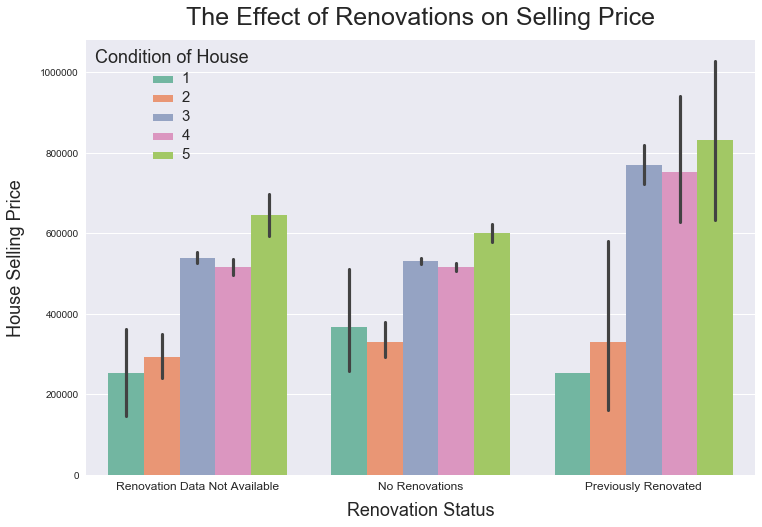

In [63]:
ax = plt.figure(figsize = (12,8))
ax = sns.barplot(x = 'yr_renovated_bins', y = 'price', data = q1_df, hue = 'condition', order = ['NaN', '0', '1'], palette = "Set2")
ax.set_ylabel('House Selling Price', fontsize = 18, labelpad = 15)
ax.set_xticklabels(('Renovation Data Not Available', 'No Renovations', 'Previously Renovated'), fontsize = 12)
ax.set_xlabel('Renovation Status', fontsize = 18, labelpad = 10)
ax.set_title('The Effect of Renovations on Selling Price', fontsize = 25, pad = 15)
ax.legend(title = 'Condition of House')
plt.setp(ax.get_legend().get_texts(), fontsize='15') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='18') # for legend title
plt.show()

In [64]:
q1_df.groupby(['yr_renovated_bins', 'condition']).describe()

price                                          \
                               count           mean            std       min   
yr_renovated_bins condition                                                    
0                 1             21.0  366497.619048  306952.712350   81000.0   
                  2            137.0  330625.102190  261868.327204   80000.0   
                  3          10676.0  531157.550955  346095.970925   82000.0   
                  4           4428.0  515187.513550  339027.043229   89000.0   
                  5           1356.0  601452.437316  402953.129089  110000.0   
1                 1              1.0  252000.000000            NaN  252000.0   
                  2              3.0  330000.000000  221133.443875  160000.0   
                  3            586.0  769554.803754  587854.924373  110000.0   
                  4            102.0  752979.049020  830960.257606  168000.0   
                  5             30.0  830423.000000  577744.395435  152900.0   
NaN               1              6.0  251666.666667  162463.124021   78000.0   
                  2             26.0  291857.692308  152069.791670  100000.0   
                  3           2426.0  539377.132729  361120.295885   90000.0   
                  4           1008.0  515255.436508  324842.244686  105000.0   
                  5            276.0  645335.706522  435941.370449  150000.0   

                                                                        
                                   25%       50%        75%        max  
yr_renovated_bins condition                                             
0                 1          196000.00  270000.0   441000.0  1500000.0  
                  2          186375.00  280000.0   375000.0  2560000.0  
                  3          326866.75  447500.0   626175.0  6890000.0  
                  4          300000.00  436250.0   625000.0  3850000.0  
                  5          349000.00  518500.0   715000.0  3650000.0  
1                 1          252000.00  252000.0   252000.0   252000.0  
                  2          205000.00  250000.0   415000.0   580000.0  
                  3          420000.00  625000.0   900000.0  7060000.0  
                  4          417437.50  594500.0   800000.0  7700000.0  
                  5          384125.00  706995.0  1162500.0  2050000.0  
NaN               1          126250.00  217500.0   396500.0   445000.0  
                  2          200000.00  239250.0   366250.0   675500.0  
                  3          329825.00  450250.0   635000.0  5570000.0  
                  4          309387.50  436500.0   620525.0  3300000.0  
                  5          364500.00  560000.0   761625.0  3070000.0

In [65]:
model = ols(formula='price ~ yr_renovated_bins * C(condition)', data=q1_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     44.84
Date:                Wed, 27 Mar 2019   Prob (F-statistic):           2.26e-80
Time:                        15:50:05   Log-Likelihood:            -2.4665e+05
No. Observations:               17340   AIC:                         4.933e+05
Df Residuals:                   17330   BIC:                         4.934e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                 3.665e+05   7.95e+04      4.610      0.000    2.11e+05    5.22e+05
yr_renovated_bins[T.1]                   -1.145e+05   3.73e+05     -0.307      0.759   -8.45e+05    6.16e+05
C(condition)[T.2]                        -3.587e+04   8.54e+04     -0.420      0.674   -2.03e+05    1.31e+05
C(condition)[T.3]                         1.647e+05   7.96e+04      2.069      0.039    8669.000    3.21e+05
C(condition)[T.4]                         1.487e+05   7.97e+04      1.866      0.062   -7516.941    3.05e+05
C(condition)[T.5]                          2.35e+05   8.01e+04      2.933      0.003    7.79e+04    3.92e+05
yr_renovated_bins[T.1]:C(condition)[T.2]  1.139e+05   4.29e+05      0.265      0.791   -7.28e+05    9.55e+05
yr_renovated_bins[T.1]:C(condition)[T.3]  3.529e+05   3.73e+05      0.946      0.344   -3.79e+05    1.08e+06
yr_renovated_bins[T.1]:C(condition)[T.4]  3.523e+05   3.75e+05      0.940      0.347   -3.82e+05    1.09e+06
yr_renovated_bins[T.1]:C(condition)[T.5]  3.435e+05   3.79e+05      0.906      0.365   -3.99e+05    1.09e+06
==============================================================================
Omnibus:                    15509.107   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           981022.377
Skew:                           4.068   Prob(JB):                         0.00
Kurtosis:                      38.939   Cond. No.                         377.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This barplot gives us much more interesting details. We can see that houses of condition 1 and 2 are sold for less when compared to houses of condition 3-5, regardless of whether the house was renovated. There is also less data in those categories though, so the results may not be as accurate. However, the fact that houses of condition 1-2 are sold for around the same amount across categories implies that the prices for these conditions are fairly consistent.

For houses of conditions 3-5, we see an expected pattern: the average selling price for renovated houses of conditions 3-5 is about 200k greater than unrenovated houses of conditions 3-5. 

However, the standard deviations for renovated houses of conditions 3-5 are still quite large. This may be because there are less data points in those categories than for unrenovated houses of conditions 3-5. We would probably still run into a large standard deviation when grouping by other categories, since the amount of data would be less when grouping by two dimensions. Let's check what grouping by view would look like just for fun.

In [66]:
q1_df = pd.concat([q1_df, df.view], axis = 1)
q1_df = q1_df.drop('condition', axis = 1)
q1_df.head()

,yr_renovated_bins,price,view
0,0,221900.0,0
1,1,538000.0,0
2,NaN,180000.0,0
3,0,604000.0,0
4,0,510000.0,0


In [67]:
#Drop nulls created due to difference in shape
q1_df.dropna(axis =0, subset=['view'], inplace = True)
q1_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21082 entries, 0 to 21596
Data columns (total 3 columns):
yr_renovated_bins    21082 non-null object
price                21082 non-null float64
view                 21082 non-null int32
dtypes: float64(1), int32(1), object(1)
memory usage: 576.5+ KB


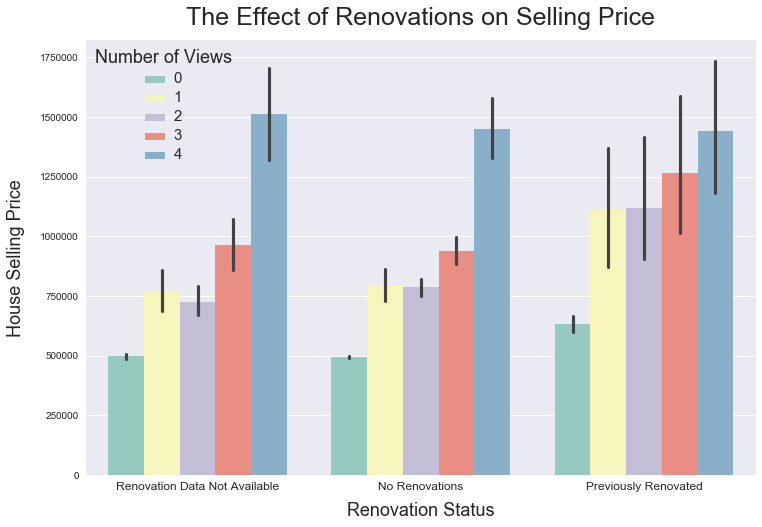

In [68]:
ax = plt.figure(figsize = (12,8))
ax = sns.barplot(x = 'yr_renovated_bins', y = 'price', data = q1_df, hue = 'view', order = ['NaN', '0', '1'], palette = "Set3")
ax.set_ylabel('House Selling Price', fontsize = 18, labelpad = 15)
ax.set_xticklabels(('Renovation Data Not Available', 'No Renovations', 'Previously Renovated'), fontsize = 12)
ax.set_xlabel('Renovation Status', fontsize = 18, labelpad = 10)
ax.set_title('The Effect of Renovations on Selling Price', fontsize = 25, pad = 15)
ax.legend(title = 'Number of Views')
plt.setp(ax.get_legend().get_texts(), fontsize='15') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='18') # for legend title
plt.show()

In [69]:
pd.options.display.float_format = '{:.2f}'.format #suppress scientific notation
q1_df.groupby(['yr_renovated_bins', 'view']).describe()

price                                            \
                          count       mean        std       min       25%   
yr_renovated_bins view                                                      
0                 0    15089.00  491925.16  277673.36  80000.00 310000.00   
                  1      249.00  794747.27  525056.51 230500.00 474950.00   
                  2      721.00  785247.58  488651.74 169317.00 472000.00   
                  3      346.00  938956.36  530927.27 259900.00 550000.00   
                  4      213.00 1450031.62  988914.31 285000.00 800000.00   
1                 0      560.00  630138.13  406199.28 110000.00 379750.00   
                  1       25.00 1110518.20  642463.11 285000.00 540000.00   
                  2       49.00 1116588.98  955340.04 308000.00 720000.00   
                  3       47.00 1264702.13 1088689.63 154000.00 781250.00   
                  4       41.00 1442036.59  900530.90 252000.00 825000.00   
NaN               0     3369.00  496671.91  298658.13  78000.00 311500.00   
                  1       53.00  768776.49  332040.86 217000.00 590000.00   
                  2      160.00  723820.68  397948.32 170000.00 480000.00   
                  3      103.00  961740.68  551149.52 265000.00 550000.00   
                  4       57.00 1512525.44  758352.94 325000.00 949950.00   

                                                         
                              50%        75%        max  
yr_renovated_bins view                                   
0                 0     430000.00  598000.00 4490000.00  
                  1     670000.00  899950.00 3650000.00  
                  2     664950.00  935000.00 3800000.00  
                  3     772500.00 1247500.00 3200000.00  
                  4    1140000.00 1800000.00 6890000.00  
1                 0     533250.00  791750.00 3400000.00  
                  1     900000.00 1680000.00 2400000.00  
                  2     950000.00 1250000.00 7060000.00  
                  3    1040000.00 1400000.00 7700000.00  
                  4    1230000.00 1740000.00 4670000.00  
NaN               0     432100.00  600000.00 5570000.00  
                  1     699950.00  828950.00 1730000.00  
                  2     631000.00  860625.00 2900000.00  
                  3     812000.00 1320000.00 2950000.00  
                  4    1280000.00 2050000.00 3300000.00

It's a good thing I checked groupby view, because there is actually a different pattern when graphing renovated houses by their views. Houses with the most views, 4, are sold at a high price whether or not they have been renovated (1.4-1.5 million dollars). 

However, houses which have been viewed 0-3 times do vary in price dependent on renovation status. Renovated houses with 0-3 views are around 100k-300k more expensive than unrenovated houses with 0-3 views. However, there is a pretty large standard deviation in renovated houses which have been viewed 1-4 times. This is likely because, again, there are less data points in those categories (look at counts, above).  

In [70]:
model = ols(formula='price ~ yr_renovated_bins * view', data=q1_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     1144.
Date:                Wed, 27 Mar 2019   Prob (F-statistic):               0.00
Time:                        15:50:06   Log-Likelihood:            -2.4529e+05
No. Observations:               17340   AIC:                         4.906e+05
Df Residuals:                   17336   BIC:                         4.906e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                     4.91e+05   2722.660    180.340      0.000    4.86e+05    4.96e+05
yr_renovated_bins[T.1]       1.495e+05   1.42e+04     10.506      0.000    1.22e+05    1.77e+05
view                         1.846e+05   3571.960     51.671      0.000    1.78e+05    1.92e+05
yr_renovated_bins[T.1]:view  2.918e+04    1.1e+04      2.652      0.008    7615.634    5.08e+04
==============================================================================
Omnibus:                    14386.988   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           830174.021
Skew:                           3.623   Prob(JB):                         0.00
Kurtosis:                      36.114   Cond. No.                         6.41
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Question 2: Do houses with the same grade change in price over time?

In [71]:
df #Holds grade variable
timeplace_df #Holds date variable
Y #Hold price target

#dataframe used to provide data for analysis will be q2_df
q2_df = pd.concat([df.grade, timeplace_df.date, Y.rename('Price')], axis = 1)
q2_df.head()

,grade,date,Price
0,7,2014-10-13,221900.00
1,7,2014-12-09,538000.00
2,6,2015-02-25,180000.00
3,7,2014-12-09,604000.00
4,8,2015-02-18,510000.00


In [72]:
q2_df.grade.value_counts()
#Note that there is only one data point for grade = 3, which is too small a sample size to use in analysis.
#Plot anyway for completion- grade is normally distributed, which implies that there should be few values in the tails
#Other grades with minimal data points include houses of grade 13, 4, and possibly 12.

7     8762
8     5922
9     2546
6     1991
10    1108
11     389
5      235
12      88
4       27
13      13
3        1
Name: grade, dtype: int64

In [73]:
q2_df.set_index('date').head()

,grade,Price
date,,
2014-10-13,7,221900.00
2014-12-09,7,538000.00
2015-02-25,6,180000.00
2014-12-09,7,604000.00
2015-02-18,8,510000.00


In [74]:
daily_df = q2_df.groupby(['date', 'grade']).mean()
daily_df.head(10)
#q2_df.Price.hist()
#sns.scatterplot(q2_df.date, q2_df.Price)
#plt.show()

Price
date       grade           
2014-05-02 6      235000.00
           7      402093.48
           8      548340.74
           9      596136.36
           10    1256333.33
2014-05-03 6      310000.00
           7      466440.00
           8      625000.00
2014-05-04 7      628000.00
           8      348475.00

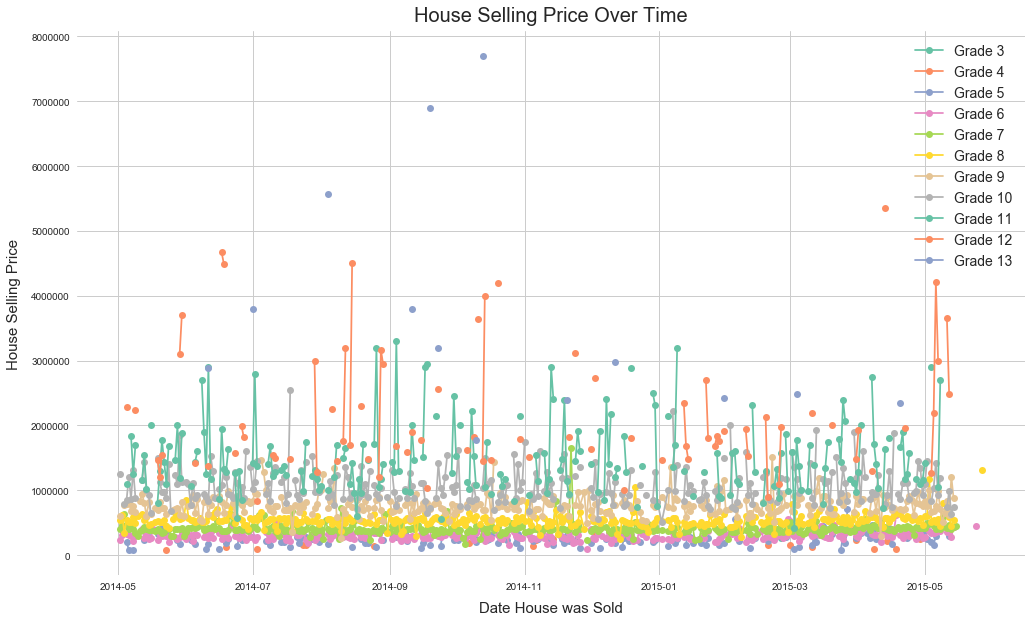

In [75]:
gr_lst = ('Grade 3', 'Grade 4', 'Grade 5', 'Grade 6', 'Grade 7', 'Grade 8', 'Grade 9', 'Grade 10', 'Grade 11', 'Grade 12', 'Grade 13')

#Setting figure aesthetics
sns.set_style('whitegrid')
plt.rcParams["image.cmap"] = "Set2"
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set2.colors)

plt.figure(figsize=(17,10))
plt.plot(daily_df['Price'].unstack('grade'), linestyle = '-', marker = 'o')
plt.xlabel('Date House was Sold', fontsize = 15, labelpad = 10)
plt.ylabel('House Selling Price', fontsize = 15, labelpad = 10)
plt.title('House Selling Price Over Time', fontsize = 20, pad = 10)
plt.legend([x for x in gr_lst], loc=0, fontsize = 14)
plt.show()

In [76]:
q2_df.groupby('grade').describe()

Price                                                         \
        count       mean        std        min        25%        50%   
grade                                                                  
3        1.00  262000.00        nan  262000.00  262000.00  262000.00   
4       27.00  212001.85   97294.50   80000.00  142500.00  200000.00   
5      235.00  250048.51  118903.17   78000.00  175000.00  229950.00   
6     1991.00  302410.59  123390.40   82000.00  215325.00  276000.00   
7     8762.00  402333.52  155481.18   90000.00  285000.00  375000.00   
8     5922.00  543525.70  218511.86  140000.00  390000.00  512250.00   
9     2546.00  774185.15  318288.75  230000.00  570000.00  721750.00   
10    1108.00 1071458.49  485021.31  316000.00  767325.00  910500.00   
11     389.00 1494643.08  702763.37  420000.00 1040000.00 1280000.00   
12      88.00 2167329.55  979230.27  835000.00 1500000.00 1820000.00   
13      13.00 3710769.23 1859545.02 1780000.00 2420000.00 2980000.00   

                             
             75%        max  
grade                        
3      262000.00  262000.00  
4      273500.00  435000.00  
5      297000.00  795000.00  
6      367750.00 1200000.00  
7      485000.00 2050000.00  
8      640000.00 3070000.00  
9      882250.00 2700000.00  
10    1250000.00 3600000.00  
11    1700000.00 7060000.00  
12    2602500.00 5350000.00  
13    3800000.00 7700000.00

Unfortunately, it seems that houses of the same grade do not experience an extremely significant increase in selling price during the span of one year. This is to be expected, as it takes years of value appreciation for house price to rise significantly. However, we can see from the color-coding that houses with progressively higher grades sell at higher prices on average, with especially great variations in price (larger standard deviations) once the grade reaches 11-13. The one house of grade 3 does not fit into this trend, but this result is likely not too accurate, as there is only one data point in that category.

Perhaps it would be interesting to see if house price varied by time of year (season). We can use the column date to divide the year's worth of data into 4 categories: winter, summer, spring, and fall. 

In [77]:
spring = range(80, 172)
summer = range(172, 264)
fall = range(264, 355)

def season(x):
    """Return season for day of year (x/365.25).

    Keyword arguments:
    x: day of year out of 365.25
    
    Spring, Summer, and Fall ranges are specified outside function. Ranges may be changed if necessary.
    
    Returns label corresponding to season.

    """
    if x in spring:
        return 'Spring'
    if x in summer:
        return 'Summer'
    if x in fall:
        return 'Fall'
    else :
        return 'Winter'

q2_df['Season'] = q2_df.set_index('date').index.dayofyear.map(season)

In [78]:
q2_df.head()

,grade,date,Price,Season
0,7,2014-10-13,221900.00,Fall
1,7,2014-12-09,538000.00,Fall
2,6,2015-02-25,180000.00,Winter
3,7,2014-12-09,604000.00,Fall
4,8,2015-02-18,510000.00,Winter


In [79]:
q2_df.Season.value_counts()

Spring    6663
Summer    5897
Fall      4892
Winter    3630
Name: Season, dtype: int64

We can already see a difference in the total amount of houses sold during the 4 seasons, with the most sold in spring, and least in winter. This result aligns with the typical advice given to home sellers: do not expect to sell the most houses during the winter. However, can we see if the prices of houses of the same grade change depending on the season?

In [80]:
q2_df.drop(['date'], axis = 1).groupby(['Season','grade']).describe()

Price                                                         \
               count       mean        std        min        25%        50%   
Season grade                                                                  
Fall   4        8.00  239625.00   76946.99  140000.00  197000.00  217500.00   
       5       62.00  243220.26  102749.11  106000.00  183250.00  232500.00   
       6      466.00  290144.72  112099.59   82000.00  210125.00  272000.00   
       7     2070.00  394376.99  152305.13   95000.00  280000.00  365000.00   
       8     1361.00  542994.41  232323.87  140000.00  387500.00  505000.00   
       9      570.00  764036.01  312115.44  256950.00  550375.00  717250.00   
       10     247.00 1042879.04  453990.47  389000.00  762500.00  895000.00   
       11      86.00 1535837.21  656832.20  550000.00 1080000.00 1300000.00   
       12      17.00 2376470.59 1117530.43 1010000.00 1620000.00 1820000.00   
       13       5.00 3610000.00 2352147.95 1780000.00 2390000.00 2980000.00   
Spring 4       10.00  216805.00  121832.68   80000.00  101250.00  223025.00   
       5       78.00  270682.69  142250.45   78000.00  175000.00  236975.00   
       6      599.00  314796.84  129769.34   84000.00  225000.00  285000.00   
       7     2763.00  414373.43  158032.47   90000.00  295000.00  389999.00   
       8     1865.00  557777.32  219905.55  160000.00  405000.00  530000.00   
       9      816.00  790732.61  319240.90  279900.00  600000.00  735500.00   
       10     376.00 1085747.53  481192.32  363000.00  769362.50  920000.00   
       11     130.00 1550186.92  795910.12  556000.00 1072500.00 1350000.00   
       12      24.00 2519583.33 1229833.78 1210000.00 1485000.00 2245000.00   
       13       2.00 2615000.00  388908.73 2340000.00 2477500.00 2615000.00   
Summer 4        5.00  175400.00   89026.96  100000.00  145000.00  150000.00   
       5       51.00  236563.65   89881.97  105500.00  182500.00  222900.00   
       6      541.00  300835.86  121312.98   85000.00  216000.00  280000.00   
       7     2365.00  397184.76  150738.81  100000.00  280000.00  372000.00   
       8     1736.00  536801.17  208721.54  162950.00  387958.75  504737.50   
       9      733.00  767245.33  310266.64  230000.00  575000.00  720000.00   
       10     323.00 1058400.24  469474.16  380000.00  775000.00  925000.00   
       11     111.00 1410502.33  646527.51  575000.00  994500.00 1200000.00   
       12      28.00 1965535.71  815592.65  835000.00 1497500.00 1690000.00   
       13       4.00 5015000.00 1502897.20 3800000.00 3800000.00 4685000.00   
Winter 3        1.00  262000.00        nan  262000.00  262000.00  262000.00   
       4        4.00  190500.00   90371.46  130000.00  145750.00  153500.00   
       5       44.00  238721.57  123063.15   85000.00  156750.00  216500.00   
       6      385.00  300198.81  127802.92   99000.00  208000.00  260000.00   
       7     1564.00  399379.89  160962.29  115000.00  280000.00  365000.00   
       8      960.00  528752.36  211542.12  149900.00  377375.00  498750.00   
       9      427.00  768023.95  337548.41  259950.00  542150.00  710000.00   
       10     162.00 1107904.51  564835.32  316000.00  760000.00  900000.00   
       11      62.00 1471679.03  651471.06  420000.00  940625.00 1300000.00   
       12      19.00 1832631.58  453625.42  900000.00 1605000.00 1840000.00   
       13       2.00 2450000.00   42426.41 2420000.00 2435000.00 2450000.00   

                                    
                    75%        max  
Season grade                        
Fall   4      273250.00  355000.00  
       5      284000.00  775000.00  
       6      349987.50  903000.00  
       7      470862.50 1650000.00  
       8      635000.00 3070000.00  
       9      880000.00 2400000.00  
       10    1250000.00 3600000.00  
       11    1882500.00 3850000.00  
       12    3120000.00 5110000.00  
       13    3200000.00 7700000.00  
Spring 4      286250.00  435000.00  
       5      333750

In [81]:
season_df = q2_df.drop(['date'], axis = 1).groupby(['Season','grade']).mean()
season_df

Price
Season grade           
Fall   4      239625.00
       5      243220.26
       6      290144.72
       7      394376.99
       8      542994.41
       9      764036.01
       10    1042879.04
       11    1535837.21
       12    2376470.59
       13    3610000.00
Spring 4      216805.00
       5      270682.69
       6      314796.84
       7      414373.43
       8      557777.32
       9      790732.61
       10    1085747.53
       11    1550186.92
       12    2519583.33
       13    2615000.00
Summer 4      175400.00
       5      236563.65
       6      300835.86
       7      397184.76
       8      536801.17
       9      767245.33
       10    1058400.24
       11    1410502.33
       12    1965535.71
       13    5015000.00
Winter 3      262000.00
       4      190500.00
       5      238721.57
       6      300198.81
       7      399379.89
       8      528752.36
       9      768023.95
       10    1107904.51
       11    1471679.03
       12    1832631.58
       13    2450000.00

In [82]:
to_graph = season_df['Price'].unstack('grade').reindex(['Spring','Summer', 'Fall', 'Winter'])

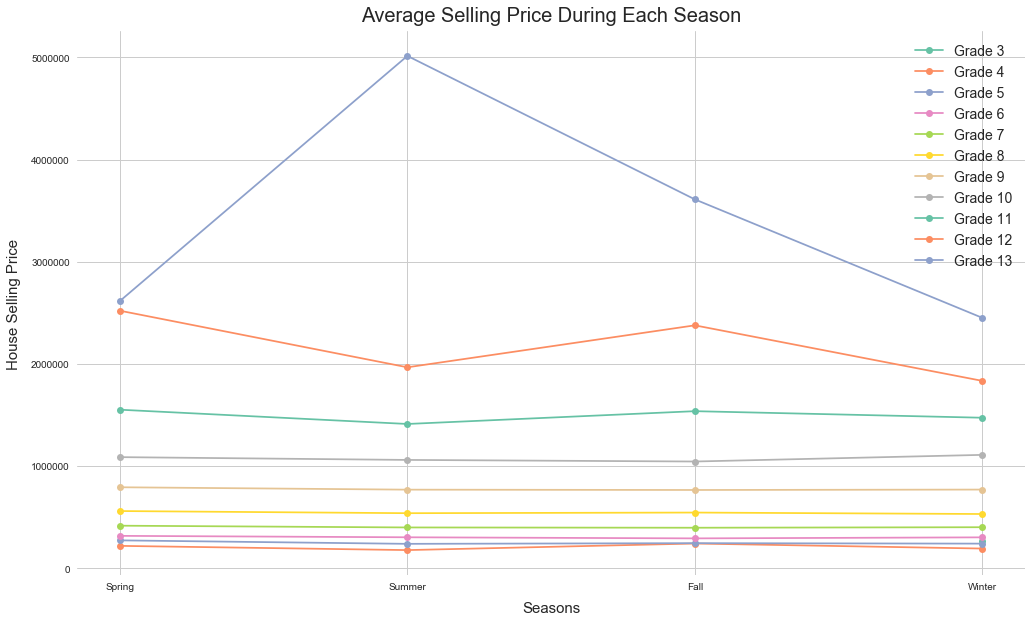

In [83]:
plt.figure(figsize=(17,10))
plt.plot(to_graph, linestyle = '-', marker = 'o')
plt.xlabel('Seasons', fontsize = 15, labelpad = 10)
plt.ylabel('House Selling Price', fontsize = 15, labelpad = 10)
plt.title('Average Selling Price During Each Season', fontsize = 20, pad = 10)
plt.legend([x for x in gr_lst], loc=0, fontsize = 14)
plt.show()

There seems to be the greatest variation in prices amongst grade 13 houses. However, there are not many data points in those categories, so the results may not be applicable (drop this category and grade 3 in the following graph). Grade 12 and 11 houses reflect a more interesting trend: highest selling prices in the spring, followed by fall, summer, and then lowest selling prices during the winter. Houses of all other grades show minimal changes in selling price regardless of season. 

In [84]:
no_13 = q2_df.loc[q2_df.grade != 13]
no_13_3 = no_13.loc[no_13.grade != 3]
no_13_3.grade.value_counts()

7     8762
8     5922
9     2546
6     1991
10    1108
11     389
5      235
12      88
4       27
Name: grade, dtype: int64

In [85]:
season_df = no_13_3.drop(['date'], axis = 1).groupby(['Season','grade']).mean()
season_df

Price
Season grade           
Fall   4      239625.00
       5      243220.26
       6      290144.72
       7      394376.99
       8      542994.41
       9      764036.01
       10    1042879.04
       11    1535837.21
       12    2376470.59
Spring 4      216805.00
       5      270682.69
       6      314796.84
       7      414373.43
       8      557777.32
       9      790732.61
       10    1085747.53
       11    1550186.92
       12    2519583.33
Summer 4      175400.00
       5      236563.65
       6      300835.86
       7      397184.76
       8      536801.17
       9      767245.33
       10    1058400.24
       11    1410502.33
       12    1965535.71
Winter 4      190500.00
       5      238721.57
       6      300198.81
       7      399379.89
       8      528752.36
       9      768023.95
       10    1107904.51
       11    1471679.03
       12    1832631.58

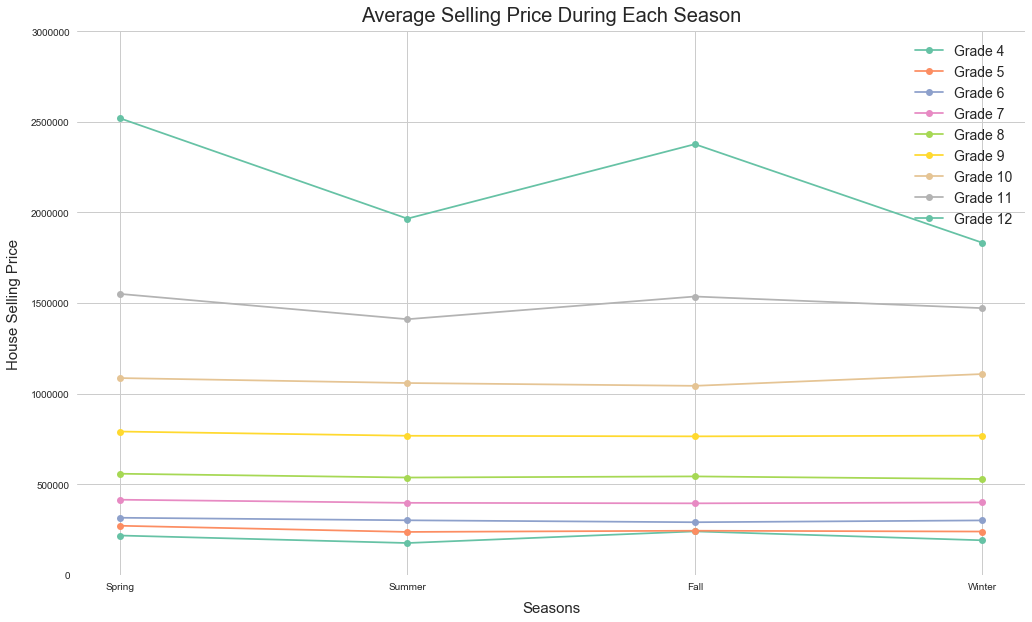

In [133]:
#gr_lst = ('Grade 3', 'Grade 4', 'Grade 5', 'Grade 6', 'Grade 7', 'Grade 8', 'Grade 9', 'Grade 10', 'Grade 11', 'Grade 12', 'Grade 13')
gr_lst = [e for e in gr_lst if e not in ('Grade 3', 'Grade 13')]

to_graph = season_df['Price'].unstack('grade').reindex(['Spring','Summer', 'Fall', 'Winter'])

plt.figure(figsize=(17,10))
plt.plot(to_graph, linestyle = '-', marker = 'o')
plt.xlabel('Seasons', fontsize = 15, labelpad = 10)
plt.ylim(0,3000000)
plt.ylabel('House Selling Price', fontsize = 15, labelpad = 10)
plt.title('Average Selling Price During Each Season', fontsize = 20, pad = 10)
plt.legend([x for x in gr_lst], loc=1, fontsize = 14)
plt.show()

In [87]:
model = ols(formula='Price ~ Season', data=no_13_3).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     10.82
Date:                Wed, 27 Mar 2019   Prob (F-statistic):           4.26e-07
Time:                        15:50:07   Log-Likelihood:            -2.9916e+05
No. Observations:               21068   AIC:                         5.983e+05
Df Residuals:                   21064   BIC:                         5.984e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         5.265e+05   5082.205    103.603      0.000    5.17e+05    5.36e+05
Season[T.Spring]  3.082e+04   6691.691      4.605      0.000    1.77e+04    4.39e+04
Season[T.Summer]  1.017e+04   6873.744      1.480      0.139   -3302.584    2.36e+04
Season[T.Winter] -4731.1221   7786.553     -0.608      0.543      -2e+04    1.05e+04
==============================================================================
Omnibus:                    16267.398   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           519183.298
Skew:                           3.451   Prob(JB):                         0.00
Kurtosis:                      26.320   Cond. No.                         5.02
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [88]:
model = ols(formula='Price ~ C(Season, Treatment(reference= "Winter")) * C(grade, Treatment(reference = 4))', data=no_13_3).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     619.8
Date:                Wed, 27 Mar 2019   Prob (F-statistic):               0.00
Time:                        15:50:07   Log-Likelihood:            -2.9171e+05
No. Observations:               21068   AIC:                         5.835e+05
Df Residuals:                   21032   BIC:                         5.838e+05
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
=============================================================================================================================================================
                                                                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                  1.905e+05   1.25e+05      1.526      0.127   -5.42e+04    4.35e+05
C(Season, Treatment(reference="Winter"))[T.Fall]                                           4.913e+04   1.53e+05      0.321      0.748   -2.51e+05    3.49e+05
C(Season, Treatment(reference="Winter"))[T.Spring]                                         2.631e+04   1.48e+05      0.178      0.859   -2.63e+05    3.16e+05
C(Season, Treatment(reference="Winter"))[T.Summer]                                         -1.51e+04   1.67e+05     -0.090      0.928   -3.43e+05    3.13e+05
C(grade, Treatment(reference=4))[T.5]                                                      4.822e+04    1.3e+05      0.370      0.711   -2.07e+05    3.04e+05
C(grade, Treatment(reference=4))[T.6]                                                      1.097e+05   1.25e+05      0.874      0.382   -1.36e+05    3.56e+05
C(grade, Treatment(reference=4))[T.7]                                                      2.089e+05   1.25e+05      1.671      0.095   -3.61e+04    4.54e+05
C(grade, Treatment(reference=4))[T.8]                                                      3.383e+05   1.25e+05      2.704      0.007    9.31e+04    5.83e+05
C(grade, Treatment(reference=4))[T.9]                                                      5.775e+05   1.25e+05      4.605      0.000    3.32e+05    8.23e+05
C(grade, Treatment(reference=4))[T.10]                                                     9.174e+05   1.26e+05      7.260      0.000     6.7e+05    1.17e+06
C(grade, Treatment(reference=4))[T.11]                                                     1.281e+06   1.29e+05      9.948      0.000    1.03e+06    1.53e+06
C(grade, Treatment(reference=4))[T.12]                                                     1.642e+06   1.37e+05     11.957      0.000    1.37e+06    1.91e+06
C(Season, Treatment(reference="Winter"))[T.Fall]:C(grade, Treatment(reference=4))[T.5]    -4.463e+04   1.61e+05     -0.278      0.781   -3.59e+05     2.7e+05
C(Season, Treatment(reference="Winter"))[T.Spring]:C(grade, Treatment(reference=4))[T.5]   5656.1241   1.55e+05      0.036      0.971   -2.98e+05     3.1e+05
C(Season, Treatment(reference="Winter"))[T.Summer]:C(grade, Treatment(reference=4))[T.5]   1.294e+04   1.75e+05      0.074      0.941    -3.3e+05    3.56e+05
C(Season, Treatment(reference="Winter"))[T.Fall]:C(grade, Treatment(reference=4))[T.6]    -5.918e+04   1.54e+05     -0.385      0.700   -3.61e+05    2.42e+05
C(Season, Treatment(reference="Winter"))[T.Spring]:C(grade, Treatment(reference=4

Earlier, we graphed all data points by grade. However, there didn't seem to be a big difference in selling price over a year. It's a bit difficult to see the relationship without a regression line, so let's try to plot the graphs with regplot, first with all date points, and then with data organized by season.

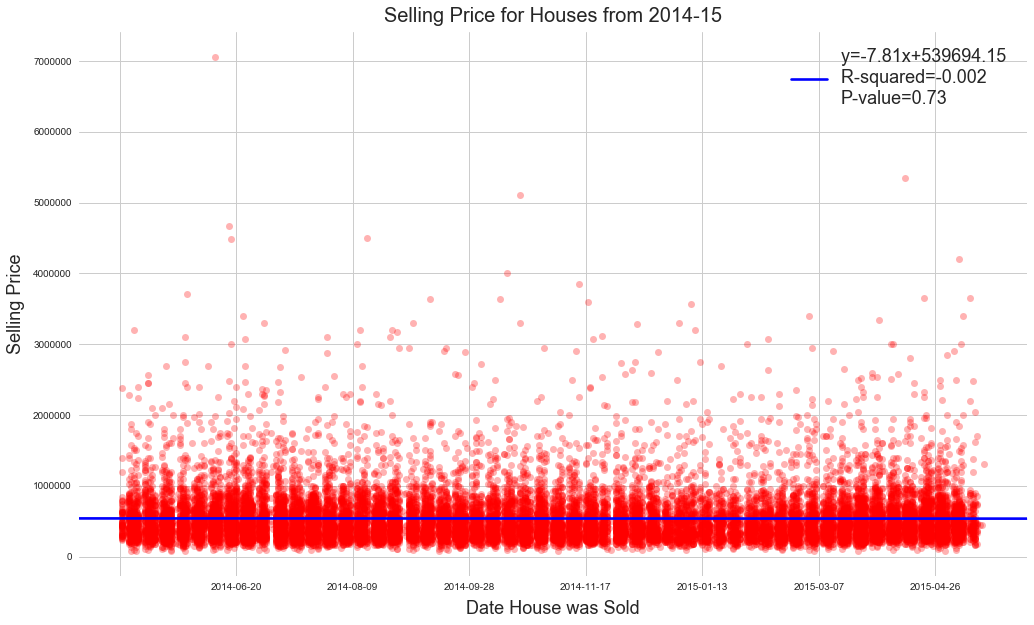

In [89]:
#Use no_13_3 dataframe, copy to new df reg_df
#This means we are excluding grades 3 and 13, since there are too few data points for those categories
#The results would not be too generalizable either, since not many sellers own houses of grades 3 and 13
reg_df = pd.DataFrame([])
reg_df = no_13_3

#Create plottable version of datetime column
reg_df = reg_df.sort_values('date')
reg_df['date_f'] = pd.factorize(reg_df['date'])[0] + 1
mapping = dict(zip(reg_df['date_f'], reg_df['date'].dt.date))

#set figure size
plt.figure(figsize=(17,10))

# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(reg_df['date_f'], reg_df['Price'])

# use line_kws to set line label for legend
ax = sns.regplot(x="date_f", y="Price", data=reg_df, color='b', 
                 scatter_kws={'color':'r', 'alpha': 0.3},
                 line_kws={'label':"y={0:.2f}x+{1:.2f} \nR-squared={2:.3f} \nP-value={3:.2f}".format(slope,intercept, r_value, p_value)})

#Use datetime column to label xticks
labels = pd.Series(ax.get_xticks()).map(mapping).fillna('')
ax.set_xticklabels(labels)

#set title and rename xlabel
ax.set_title('Selling Price for Houses from 2014-15', fontsize=(20), pad = 10)
ax.set_xlabel('Date House was Sold', fontsize = 18, labelpad = 8)
ax.set_ylabel('Selling Price', fontsize = 18, labelpad = 8)

# plot legend and enlarge font size
ax.legend(prop=dict(size=18))

plt.show()

Well from both the p value and r-squared for that previous regression, clearly there is pretty much no linear relationship between day sold and price. However, let's see if we can find anything significant when iterating over each grade category.

In [90]:
#Preparation to plot regplot between date and price, which will visualize regression line and confidence interval
#separate dataframe into separate dataframes, one for each grade
#use loc to separate by grade = ?

grade_dfs = []
grades = list(reg_df.grade.value_counts().index)
grades.sort()
for num in grades:
    name_of_df = 'df_'+str(num) 
    name_of_df = reg_df.loc[reg_df['grade'] == num]
    grade_dfs.append(name_of_df)
    
#grade_dfs is list which holds a dataframe for each grade

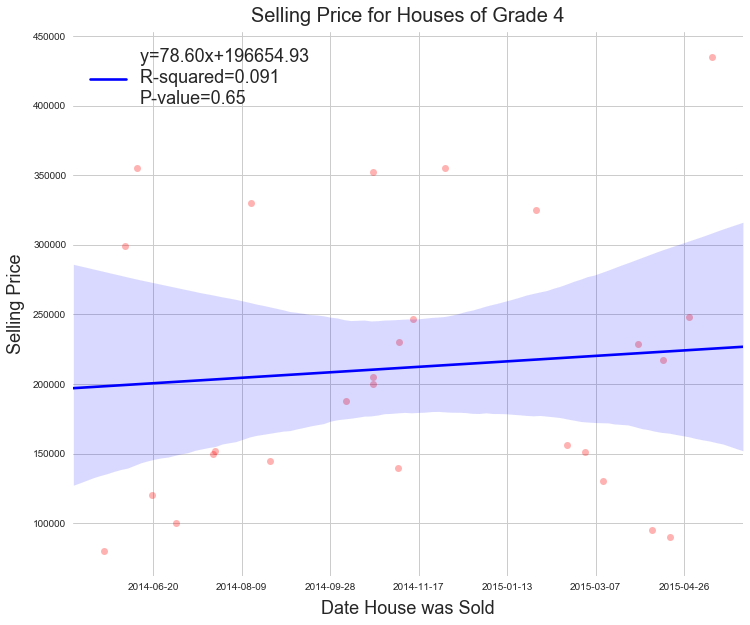

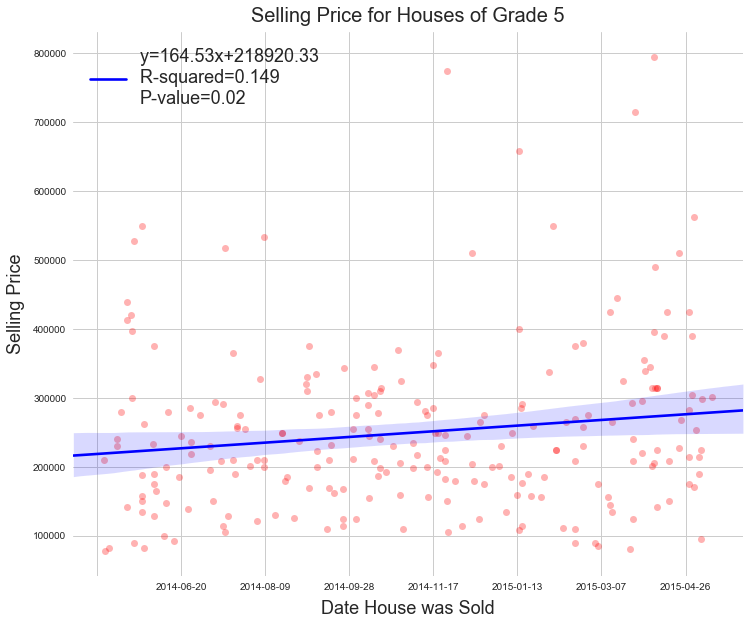

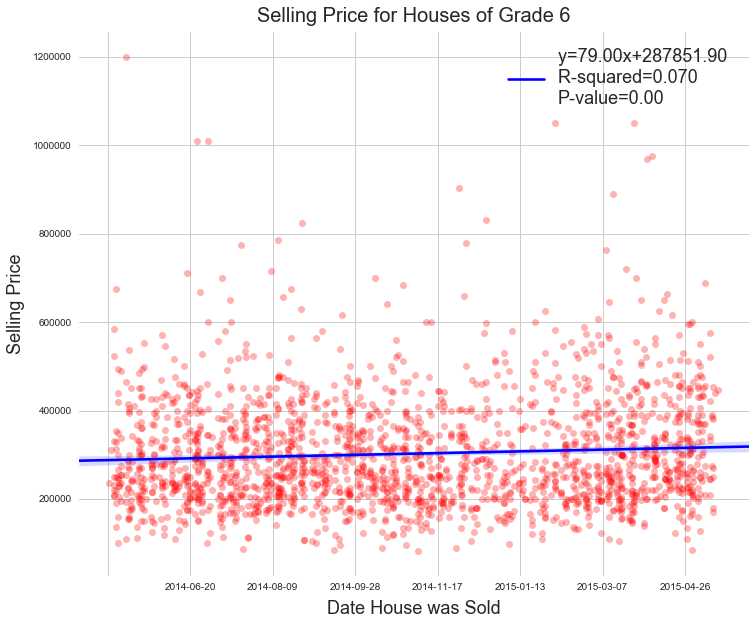

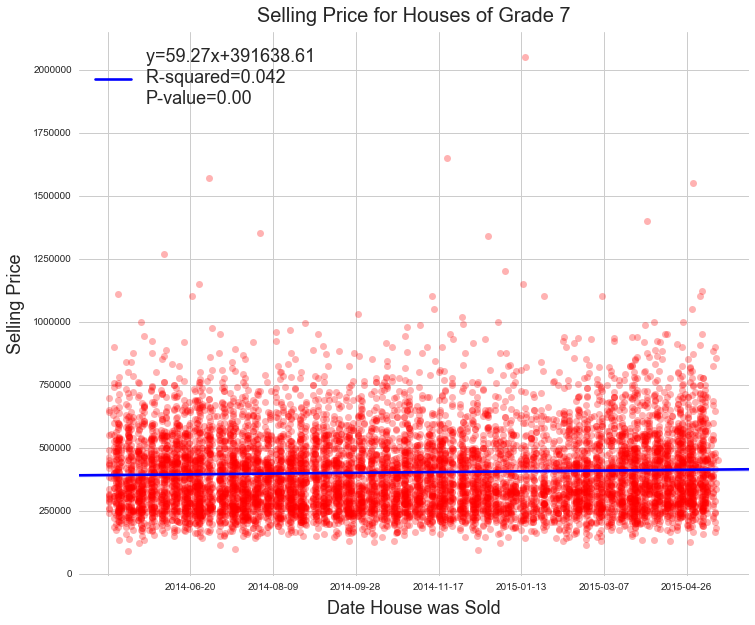

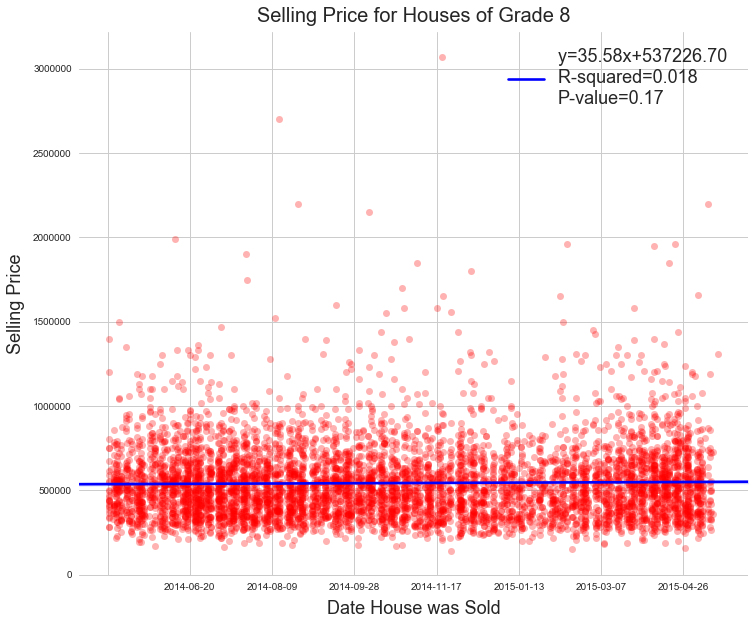

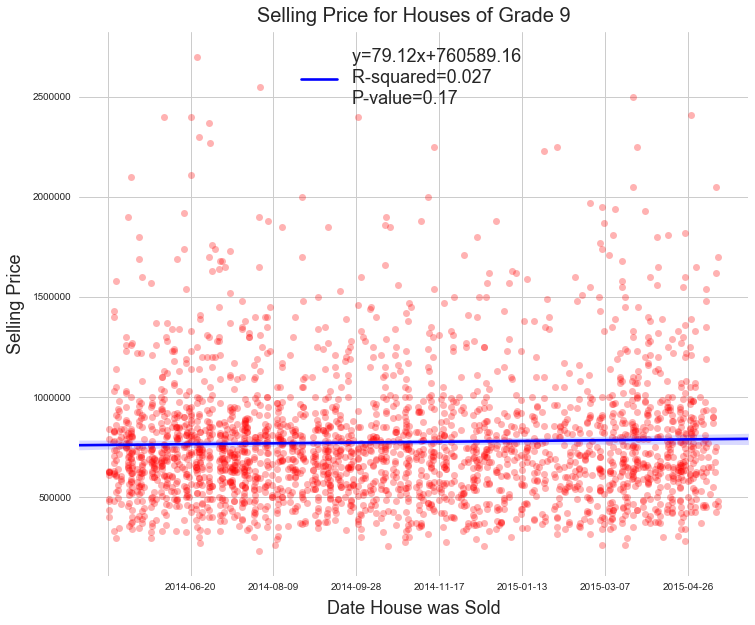

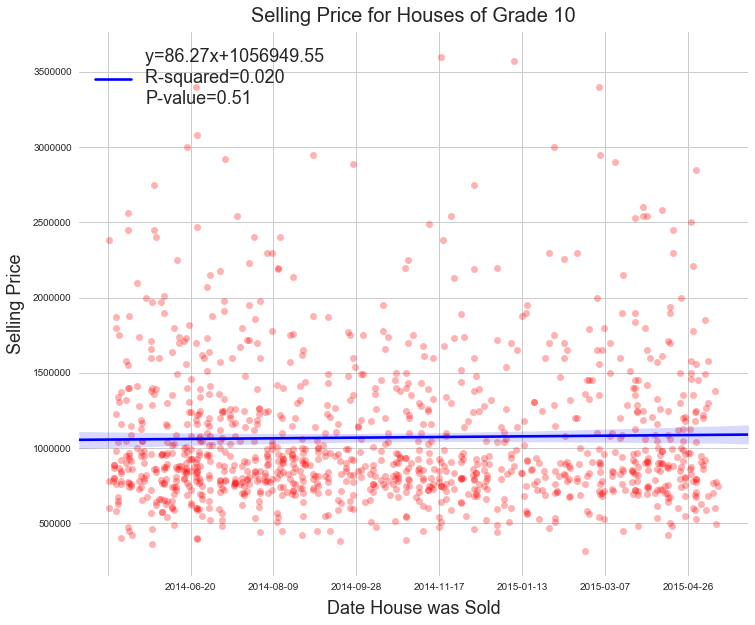

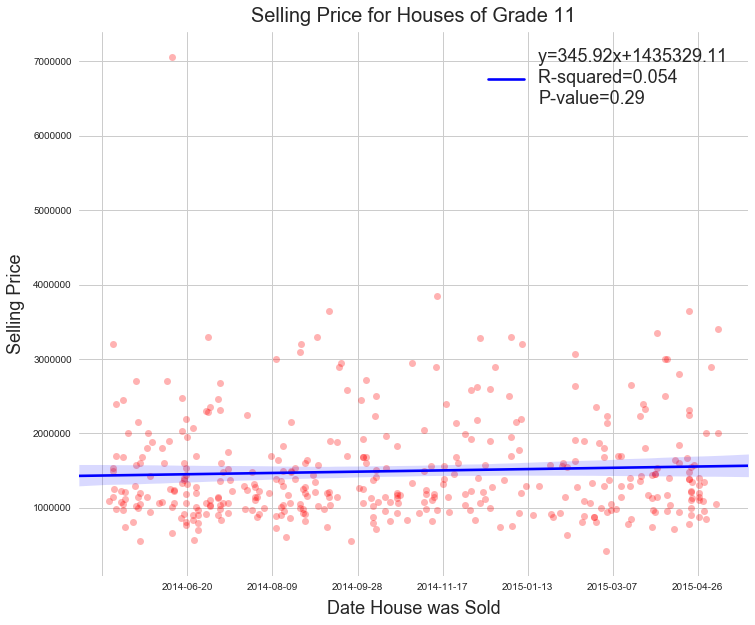

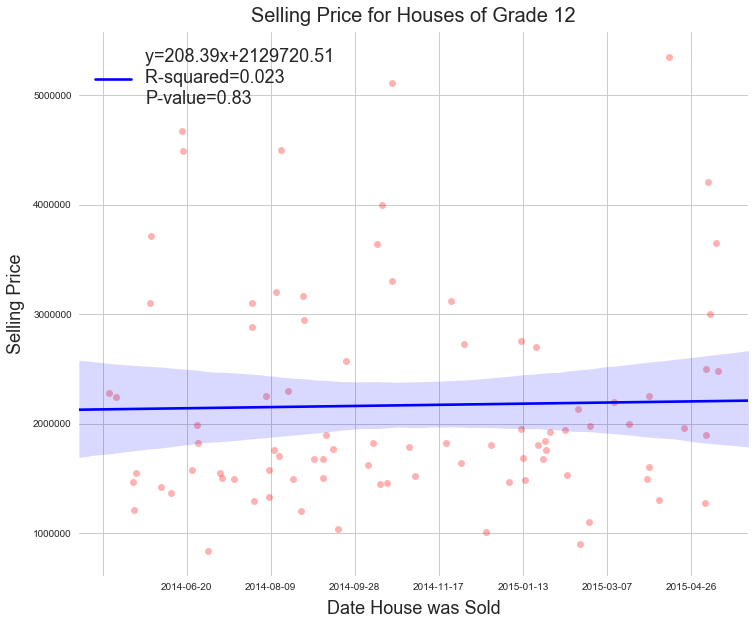

In [91]:
#Plotting regplot between date and price for each grade by iterating through grade_dfs
#Grades 4-12

for i in range(0, len(grade_dfs)):

    #set figure size
    plt.figure(figsize=(12,10))

    # get coeffs of linear fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(grade_dfs[i]['date_f'], grade_dfs[i]['Price'])

    # use line_kws to set line label for legend
    ax = sns.regplot(x="date_f", y="Price", data=grade_dfs[i], color='b', 
                     scatter_kws={'color':'r', 'alpha': 0.3},
                     line_kws={'label':"y={0:.2f}x+{1:.2f} \nR-squared={2:.3f} \nP-value={3:.2f}".format(slope,intercept, r_value, p_value)})

    #Use datetime column to label xticks
    labels = pd.Series(ax.get_xticks()).map(mapping).fillna('')
    ax.set_xticklabels(labels)

    #set title and rename xlabel
    ax.set_title('Selling Price for Houses of Grade '+ str(i+4), fontsize=(20), pad = 10)
    ax.set_xlabel('Date House was Sold', fontsize = 18, labelpad = 8)
    ax.set_ylabel('Selling Price', fontsize = 18, labelpad = 8)

    # plot legend and enlarge font size
    ax.legend(prop=dict(size=18))

    plt.show()

We'll exclude the grade categories with a linear regression p-value above 0.05, since the results are not significant.

Houses of grade 5 had a p-value = 0.02, but its r-squared was fairly low, at 0.149. Interestingly enough, there was an overall positive trend over time, with these houses gaining approximately 165$ in value daily over the year.

Houses of grade 6 had a p-value below 0.05 with an even lower r-squared than grade 5 houses. These houses gained approximately 79$ in value daily over the year.

Houses of grade 7 had a low p-value (significant), but a low r-squared. Houses gained approximately 59$ in value daily.

## Question 3: Is there a significant difference in price depending on number of bathrooms?

In [92]:
#Use num_df and Y to create new q3_df for question 3
q3_df = pd.concat([df.bathrooms, Y.rename('Price')], axis = 1)
q3_df.head()

,bathrooms,Price
0,1.00,221900.00
1,2.25,538000.00
2,1.00,180000.00
3,3.00,604000.00
4,2.00,510000.00


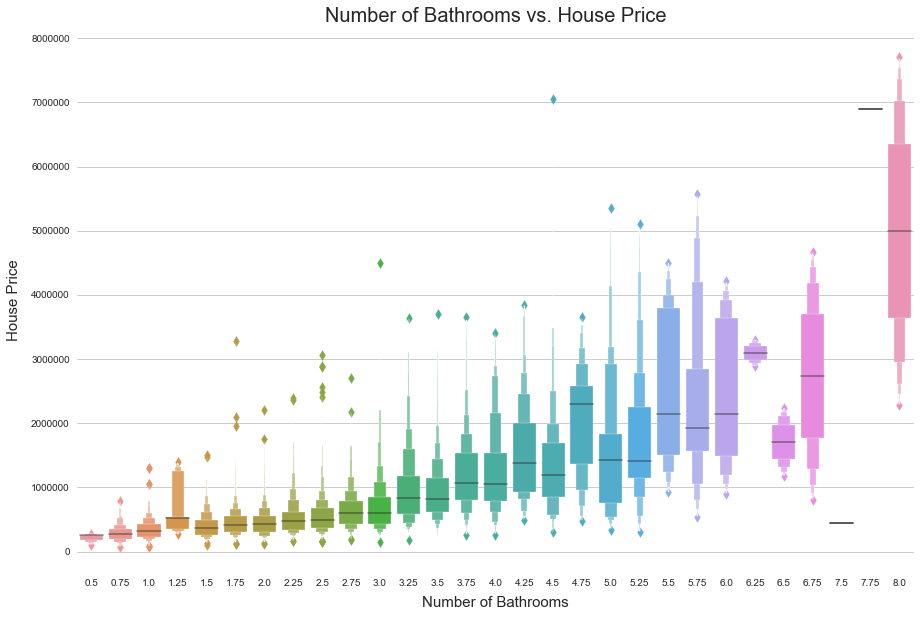

In [93]:
##Use seaborn boxenplots to visualize
##plotting an discrete variable (bathrooms) vs. a continuous variable (Price)
fig, ax = plt.subplots(figsize = (15,10))
ax = sns.boxenplot(x="bathrooms", y="Price", data=q3_df)
ax.set_title('Number of Bathrooms vs. House Price', fontsize = 20)
plt.ticklabel_format(style='plain', axis='y')
ax.set_ylabel('House Price', fontsize = 15, labelpad = 10)
ax.set_xlabel('Number of Bathrooms', fontsize = 15, labelpad = 8)
plt.show()

In [94]:
model = ols(formula='Price ~ bathrooms -1', data=q3_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                 7.117e+04
Date:                Wed, 27 Mar 2019   Prob (F-statistic):               0.00
Time:                        15:50:12   Log-Likelihood:            -2.9663e+05
No. Observations:               21082   AIC:                         5.933e+05
Df Residuals:                   21081   BIC:                         5.933e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
bathrooms   2.548e+05    955.016    266.783      0.000    2.53e+05    2.57e+05
==============================================================================
Omnibus:                    16631.757   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           827095.094
Skew:                           3.394   Prob(JB):                         0.00
Kurtosis:                      32.925   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [95]:
q3_df.groupby('bathrooms').describe()

Price                                                         \
            count       mean        std        min        25%        50%   
bathrooms                                                                  
0.50         3.00  212333.33   89940.72  109000.00  182000.00  255000.00   
0.75        71.00  294936.65  139021.96   80000.00  201000.00  275000.00   
1.00      3748.00  347334.57  154272.40   78000.00  230987.50  320000.00   
1.25         9.00  621772.22  408881.71  275000.00  360000.00  516500.00   
1.50      1418.00  409362.17  193641.48  107000.00  265275.00  370000.00   
1.75      2978.00  454257.23  202050.85  115000.00  310000.00  420100.00   
2.00      1882.00  456903.66  204918.05  115000.00  300000.00  423500.00   
2.25      2005.00  533588.09  279611.27  160000.00  340000.00  472000.00   
2.50      5242.00  554601.75  268796.46  153503.00  365000.00  499950.00   
2.75      1160.00  659796.07  312002.37  183750.00  435000.00  605000.00   
3.00       735.00  710594.64  430272.13  154000.00  435500.00  605000.00   
3.25       570.00  969947.65  567722.17  176000.00  589625.00  829997.50   
3.50       718.00  931473.78  467749.67  216650.00  617462.50  818000.00   
3.75       152.00 1198800.86  595848.85  255000.00  801875.00 1070000.00   
4.00       135.00 1268171.31  695884.36  265000.00  792700.00 1050000.00   
4.25        77.00 1531709.09  764803.45  490000.00  930000.00 1380000.00   
4.50        96.00 1361964.19  897466.99  303500.00  855000.00 1190000.00   
4.75        23.00 2022299.57  867272.45  480000.00 1360000.00 2300000.00   
5.00        19.00 1645131.58 1217347.73  343000.00  762250.00 1430000.00   
5.25        13.00 1817961.54 1241665.49  300000.00 1150000.00 1420000.00   
5.50         9.00 2521666.67 1330737.58  925000.00 1500000.00 2150000.00   
5.75         4.00 2492500.00 2153777.69  540000.00 1575000.00 1930000.00   
6.00         5.00 2478000.00 1407469.36  900000.00 1490000.00 2150000.00   
6.25         2.00 3095000.00  289913.78 2890000.00 2992500.00 3095000.00   
6.50         2.00 1710000.00  749533.19 1180000.00 1445000.00 1710000.00   
6.75         2.00 2735000.00 2736503.24  800000.00 1767500.00 2735000.00   
7.50         1.00  450000.00        nan  450000.00  450000.00  450000.00   
7.75         1.00 6890000.00        nan 6890000.00 6890000.00 6890000.00   
8.00         2.00 4990000.00 3832518.75 2280000.00 3635000.00 4990000.00   

                                 
                 75%        max  
bathrooms                        
0.50       264000.00  273000.00  
0.75       355000.00  785000.00  
1.00       425000.00 1300000.00  
1.25       545000.00 1390000.00  
1.50       495000.00 1500000.00  
1.75       555000.00 3280000.00  
2.00       560000.00 2200000.00  
2.25       620000.00 2400000.00  
2.50       675000.00 3070000.00  
2.75       796625.00 2700000.00  
3.00       850000.00 4490000.00  
3.25      1180000.00 3640000.00  
3.50      1140000.00 3710000.00  
3.75      1532500.00 3650000.00  
4.00      1535000.00 3400000.00  
4.25      2000000.00 3850000.00  
4.50      1700000.00 7060000.00  
4.75      2585000.00 3650000.00  
5.00      1840000.00 5350000.00  
5.25      2250000.00 5110000.00  
5.50      3800000.00 4500000.00  
5.75      2847500.00 5570000.00  
6.00      3640000.00 4210000.00  
6.25      3197500.00 3300000.00  
6.50      1975000.00 2240000.00  
6.75      3702500.00 4670000.00  
7.50       450000.00  450000.00  
7.75      6890000.00 6890000.00  
8.00      6345000.00 7700000.00

`There seems to be a general increase in price with increasing number of bathrooms in a house, up until 5.0 bathrooms. Furthermore, the range of selling prices increases as the number of bathrooms increases.` 
The increase in price ranges from approximately `$`250,000 at 0.75 bathrooms to approximately `$`1,000,000 at 4.0 bathrooms. It seems that depending on the situation, adding a bathroom may be able to increase house price. In fact, the mean housing price does increase with the number of bathrooms, even when increasing number of bathrooms by 0.25 increments. However, this conclusion is not definite, as these analyses can only infer correlations, not causations. The more applicable conclusion would be that total number of bathrooms corresponds to an increase in price. Therefore, purchasing a house with even 0.25 more bathrooms overall would correspond with a greater price. 

The dip in price at 5.0 may be simply an artifact of low sample size, or indicative of a larger trend: it is possible that beyond a certain number of bathrooms, there is no longer a corresponding positive increase in the house price.

In [96]:
#Just exploring bathrooms * waterfront to see if there is any relationship
#q3_df.drop(['waterfront_bins'], axis= 1, inplace = True)
q3_df = pd.concat([q3_df, df.waterfront_bins], axis = 1)

In [97]:
#Get rid of nulls in waterfront_bins 
q3_df = q3_df.loc[q3_df.waterfront_bins != 'NaN']
q3_df.waterfront_bins.value_counts(dropna = False)

0    18608
1      141
Name: waterfront_bins, dtype: int64

In [98]:
#Rename 0.0 --> No Waterfront View
#Rename 1.0 --> Waterfront View
q3_df.waterfront_bins = q3_df.waterfront_bins.astype('category')
q3_df.waterfront_bins.cat.rename_categories({'0': 'No Waterfront View', '1': 'Waterfront View'}, inplace = True)
q3_df.waterfront_bins.value_counts()

No Waterfront View    18608
Waterfront View         141
Name: waterfront_bins, dtype: int64

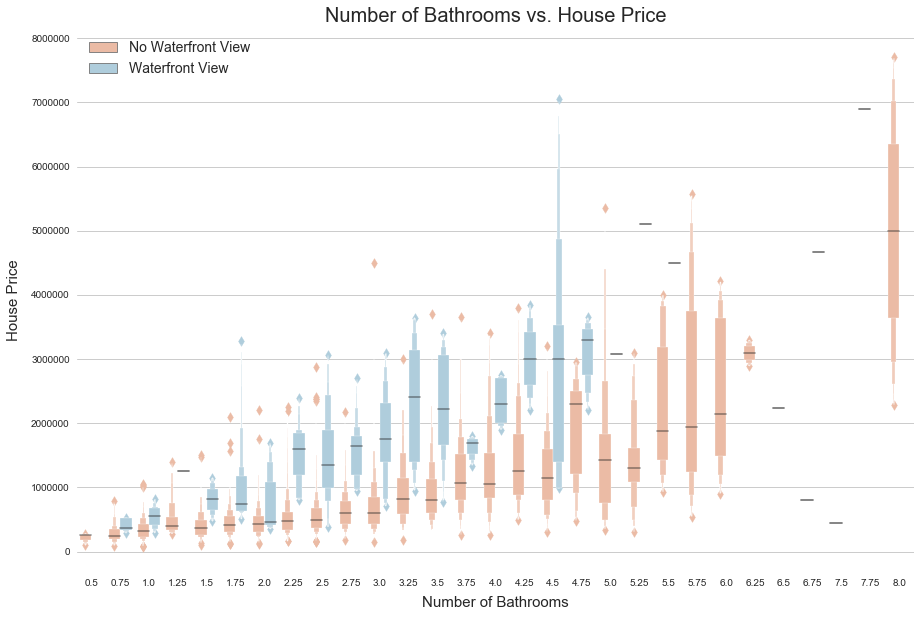

In [99]:
fig, ax = plt.subplots(figsize = (15,10))
ax = sns.boxenplot(x="bathrooms", y="Price", hue = 'waterfront_bins', data=q3_df, palette = 'RdBu')
ax.set_title('Number of Bathrooms vs. House Price', fontsize = 20)
plt.ticklabel_format(style='plain', axis='y')
ax.set_ylabel('House Price', fontsize = 15, labelpad = 10)
ax.set_xlabel('Number of Bathrooms', fontsize = 15, labelpad = 8)
ax.legend(fontsize = 14)
plt.show()

In [100]:
q3_df.groupby(['waterfront_bins']).describe()

Price                                            \
                      count       mean        std       min       25%   
waterfront_bins                                                         
No Waterfront View 18608.00  532801.55  345468.68  78000.00 320000.00   
Waterfront View      141.00 1705708.16 1122168.43 285000.00 820000.00   

                                                    bathrooms                 \
                          50%        75%        max     count mean  std  min   
waterfront_bins                                                                
No Waterfront View  450000.00  638500.00 7700000.00  18608.00 2.11 0.76 0.50   
Waterfront View    1580000.00 2300000.00 7060000.00    141.00 2.70 1.10 0.75   

                                        
                    25%  50%  75%  max  
waterfront_bins                         
No Waterfront View 1.75 2.25 2.50 8.00  
Waterfront View    1.75 2.50 3.25 6.75

In [101]:
model = ols(formula='Price ~ bathrooms : C(waterfront_bins) -1', data=q3_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                 3.555e+04
Date:                Wed, 27 Mar 2019   Prob (F-statistic):               0.00
Time:                        15:50:13   Log-Likelihood:            -2.6306e+05
No. Observations:               18749   AIC:                         5.261e+05
Df Residuals:                   18747   BIC:                         5.261e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
bathrooms:C(waterfront_bins)[No Waterfront View]  2.506e+05    978.919    256.046      0.000    2.49e+05    2.53e+05
bathrooms:C(waterfront_bins)[Waterfront View]     6.457e+05   8678.345     74.406      0.000    6.29e+05    6.63e+05
==============================================================================
Omnibus:                    13419.374   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           580510.416
Skew:                           2.953   Prob(JB):                         0.00
Kurtosis:                      29.612   Cond. No.                         8.87
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Houses with a waterfront view are on average 1mil dollars more expensive than houses without. Houses with a waterfront view also have a greater average number of bathrooms compared to houses without a waterfront view (2.43 vs. 2.08 bathrooms, respectively). This is reflected both in the graph and the actual means calculated with .describe(). Furthermore, when looking at the model of interactions, houses with a waterfront view have a greater slope than houses without- implying that the waterfront views of these houses have a greater positive effect on their selling price than houses without a waterfront view. 

## Time for Modelling!
* Find which predictors best predict housing price
* Use num_df and cat_df when investigating numerical and categorical variables, respectively
* timeplace_df, dropped_df available as well 
* Feature ranking with feature elimination to choose predictors
* Create a model based on predictors suggested by feature ranking
* Holdout validation for testing

In [102]:
cat_df.head() #Dummy variables for cond, grade, view, water, yr_renov
num_df.head() #Includes: bedrooms, bathrooms, sqft_lot, floors, sqft_basement
timeplace_df.head() #Includes: date, yr_built, zipcode
#Let's use the predictors in cat_df and num_df to create an initial model
y.head()
#y holds the log transformed, standardized price target

0   -1.40
1    0.28
2   -1.80
3    0.50
4    0.18
Name: price, dtype: float64

In [103]:
cat_df.head()
#cat_df.rename(columns={'water_0.0': 'water_0', 'water_1.0': 'water_1', 'yr_renov_0.0': 'yr_renov_0', 'yr_renov_1.0': 'yr_renov_1'}, inplace=True)

,cond_1,cond_2,cond_3,cond_4,cond_5,grade_3,grade_4,grade_5,grade_6,grade_7,...,grade_10,grade_11,grade_12,grade_13,water_0,water_1,water_NaN,yr_renov_0,yr_renov_1,yr_renov_NaN
0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,1,0,0
1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
2,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
3,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [104]:
cat_df.columns[5:15]

Index(['grade_3', 'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_8',
       'grade_9', 'grade_10', 'grade_11', 'grade_12'],
      dtype='object')

In [105]:
#Use num_df and cat_df for predictors.
#Use y for target

#First check cat_df variables for any predictors with p-value above 0.05
#dropped one category from each of the dummy variables (Dropped: waterfront_NaN, yr_renov_NaN, cond_5, grade_13)
cols_waterfront = cat_df.columns[-6:-4] 
cols_renov = cat_df.columns[-3:-1] 
cols_cond = cat_df.columns[0:4] 
cols_grade = cat_df.columns[5:15] 

#add target variable y in preparation for modelling
caty_df = pd.concat((cat_df, y.rename('Price')), axis=1)

cols = [cols_waterfront, cols_renov, cols_cond, cols_grade]
for col in cols:
    sum_cols = '+'.join(col)
    f = 'Price~' + sum_cols
    m = ols(formula = f, data = caty_df, missing = 'drop').fit()
    print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     309.7
Date:                Wed, 27 Mar 2019   Prob (F-statistic):          2.84e-133
Time:                        15:50:13   Log-Likelihood:                -29609.
No. Observations:               21082   AIC:                         5.922e+04
Df Residuals:                   21079   BIC:                         5.925e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0204      0.020     -1.001      0.3

R-squared and Adjusted R-squared for categorical variables were as follows:
* waterfront 
    ** r-squared: 0.029, Adj. r-squared: 0.028.
    ** Exclude this from analysis due to P-value of 0.733 for water_0
* yr_renovated 
    ** r-squared: 0.011, Adj. r-squared: 0.011
    ** Exclude this from analysis due to P-value of 0.374 for yr_renov_0
* condition 
    ** r-squared: 0.014, Adj. r-squared: 0.014
* grade 
    ** r-squared: 0.497, Adj. r-squared: 0.496
    
Based on this analysis, it would be more effective to use grade and condition when creating the final model.
All p-values except water_0 and yr_renov_0 are below threshold of 0.05.

Time to check the r-squared values for numerical variables.

In [106]:
col_names = num_df.describe().columns
numy_df = pd.concat((num_df, y.rename('Price')), axis=1)
results_log = [['ind_var', 'r_squared', 'intercept', 'slope', 'p-value' ]]
for idx, val in enumerate(col_names):
    print ("Kings County Housing: Price~" + val)

    f = 'price~' + val
    model = ols(formula=f, data=numy_df).fit()
    X_new = pd.DataFrame({val: [numy_df[val].min(), numy_df[val].max()]});
    preds = model.predict(X_new)
    results_log.append([val, model.rsquared, model.params[0], model.params[1], model.pvalues[1] ])
    print(results_log[idx+1], '\n')

Kings County Housing: Price~bedrooms
['bedrooms', 0.11690843421819963, 13.048216725680398, 0.17997959386861281, 0.0] 

Kings County Housing: Price~bathrooms
['bathrooms', 0.26999400394509132, 13.048216725680515, 0.27351264237493744, 0.0] 

Kings County Housing: Price~sqft_living
['sqft_living', 0.45487390817074247, 13.048216725680392, 0.35501430961992203, 0.0] 

Kings County Housing: Price~sqft_lot
['sqft_lot', 0.019126438506744781, 13.048216725680454, 0.072797656670342659, 1.5829053476089259e-90] 

Kings County Housing: Price~floors
['floors', 0.096087434883229461, 13.048216725680449, 0.16316749471073355, 0.0] 

Kings County Housing: Price~view
['view', 0.11956224062343945, 12.992706415982308, 0.23790777577886313, 0.0] 

Kings County Housing: Price~sqft_basement
['sqft_basement', 0.10000467070713126, 12.93848791056223, 1.8152558128918814, 0.0] 



All p-values are below 0.05. Some variables seem to impact r-squared more significantly (sqft_living, bedrooms, bathrooms, sqft_basement).

In [107]:
timeplace_df.columns

Index(['date', 'yr_built', 'zipcode', 'lat', 'long'], dtype='object')

In [108]:
col_names = ['yr_built', 'zipcode', 'lat', 'long']
tpy_df = pd.concat((timeplace_df, y.rename('Price')), axis=1)
results_log = [['ind_var', 'r_squared', 'intercept', 'slope', 'p-value' ]]
for idx, val in enumerate(col_names):
    print ("Kings County Housing: Price~" + val)

    f = 'price~' + val
    model = ols(formula=f, data=tpy_df).fit()
    X_new = pd.DataFrame({val: [tpy_df[val].min(), tpy_df[val].max()]});
    preds = model.predict(X_new)
    results_log.append([val, model.rsquared, model.params[0], model.params[1], model.pvalues[1] ])
    print(results_log[idx+1], '\n')

Kings County Housing: Price~yr_built
['yr_built', 0.0065900901053499439, 10.175863096803013, 0.0014572905222938123, 3.6455764721831575e-32] 

Kings County Housing: Price~zipcode
['zipcode', 0.0014841133580336674, 50.204127118355345, -0.00037884096199994929, 2.202152722191552e-08] 

Kings County Housing: Price~lat
['lat', 0.20208616483299657, 12.35749570196476, 1.0616868541063536, 0.0] 

Kings County Housing: Price~long
['long', 0.0026230655016864501, 12.989706443316443, 0.23085297236181002, 1.0007479836359499e-13] 



Seems like lat impacts r-squared more significantly. 

From previous analysis, these variables seem to have the most impact on r-squared:
* From numerical variables:   
    * sqft_living, bedrooms, bathrooms, sqft_basement, view
* From categorical variables:
    * grade
* From time/place variables:
    * lat

## Create model by considering all variables (p < 0.05)
* Before running the model with variables of high r-squared values, create a model when considering all variables with a p value lower than 0.05
* Get MSE's through k-fold validation

In [109]:
#Which columns contain condition and grade predictors in cat_df?
cat_df.iloc[:,0:16].head()

#Which columns contain yr_built, zipcode, lat, and long in timeplace_df?
timeplace_df.iloc[:,1:5].head()

,yr_built,zipcode,lat,long
0,1955,98178,0.57,0.22
1,1951,98125,0.91,0.17
2,1933,98028,0.94,0.24
3,1965,98136,0.59,0.10
4,1987,98074,0.74,0.39


In [110]:
#Create model_df to use when modelling all variables with p-values < 0.05
model_df = pd.concat([num_df, cat_df.iloc[:,0:16], timeplace_df.iloc[:,1:5]], axis = 1)
print(model_df.columns, model_df.shape[1])

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'view',
       'sqft_basement', 'cond_1', 'cond_2', 'cond_3', 'cond_4', 'cond_5',
       'grade_3', 'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_8',
       'grade_9', 'grade_10', 'grade_11', 'grade_12', 'grade_13', 'yr_built',
       'zipcode', 'lat', 'long'],
      dtype='object') 27


In [111]:
# select all 27 predictors 
cv_10_results = cross_val_score(linreg, model_df, y, cv=10, scoring="neg_mean_squared_error")
cv_10_results

array([-0.23814871, -0.25310168, -0.23979305, -0.24444678, -0.22933949,
       -0.24563035, -0.2402595 , -0.24955824, -0.2408382 , -0.21345957])

In [112]:
cv_10_results.mean()

-0.23945755785179862

Most MSE's are hovering around the 0.24 range, which is pretty good. 

Rank features by order:

In [113]:
rfe = RFE(linreg, n_features_to_select = 1)
rfe.fit(model_df, np.ravel(y))

names = list(model_df.columns)
print(sorted(zip(map(lambda x: round(x,4), rfe.ranking_), names)))

[(1, 'grade_13'), (2, 'grade_12'), (3, 'grade_11'), (4, 'lat'), (5, 'grade_4'), (6, 'grade_5'), (7, 'grade_6'), (8, 'grade_7'), (9, 'grade_3'), (10, 'grade_8'), (11, 'long'), (12, 'sqft_living'), (13, 'grade_10'), (14, 'cond_5'), (15, 'cond_1'), (16, 'view'), (17, 'cond_4'), (18, 'cond_2'), (19, 'bedrooms'), (20, 'cond_3'), (21, 'floors'), (22, 'grade_9'), (23, 'bathrooms'), (24, 'sqft_basement'), (25, 'sqft_lot'), (26, 'yr_built'), (27, 'zipcode')]


Let's see how the R-squared looks with all predictors selected.

In [114]:
linreg.fit(model_df,y) 
yhat = linreg.predict(model_df) 
SS_Residual = np.sum((y-yhat)**2) 
SS_Total = np.sum((y-np.mean(y))**2) 
r_squared = 1 - (float(SS_Residual))/SS_Total 
print('R-squared:', r_squared) 
adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-model_df.shape[1]-1) 
print('Adjusted R-squared:', adjusted_r_squared, '\n') 

R-squared: 0.763210088427
Adjusted R-squared: 0.762906425104 



That R-squared value looks great! But as we saw above, not all variables contributed equally in determining price. We can try to make a model off of the predictors with greatest r-squared values: sqft_living, bedrooms, grade, view, and lat.

In [115]:
cat_df.iloc[:,5:16].head()
#timeplace_df.lat

,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13
0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0


In [116]:
model2_df = pd.concat([num_df.bedrooms, num_df.sqft_living, num_df.view, cat_df.iloc[:,5:16], timeplace_df.lat], axis = 1)
print(model2_df.columns, model2_df.shape[1])

Index(['bedrooms', 'sqft_living', 'view', 'grade_3', 'grade_4', 'grade_5',
       'grade_6', 'grade_7', 'grade_8', 'grade_9', 'grade_10', 'grade_11',
       'grade_12', 'grade_13', 'lat'],
      dtype='object') 15


In [117]:
linreg.fit(model2_df,y) 
yhat = linreg.predict(model2_df) 
SS_Residual = np.sum((y-yhat)**2) 
SS_Total = np.sum((y-np.mean(y))**2) 
r_squared = 1 - (float(SS_Residual))/SS_Total 
print('R-squared:', r_squared) 
adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-model2_df.shape[1]-1) 
print('Adjusted R-squared:', adjusted_r_squared, '\n') 

R-squared: 0.726612022287
Adjusted R-squared: 0.726417356966 



In [118]:
cv_10_results = cross_val_score(linreg, model_df, y, cv=10, scoring="neg_mean_squared_error")
cv_10_results

array([-0.23814871, -0.25310168, -0.23979305, -0.24444678, -0.22933949,
       -0.24563035, -0.2402595 , -0.24955824, -0.2408382 , -0.21345957])

In [119]:
cv_10_results.mean()

-0.23945755785179862

Depending on the request of stakeholders, we could choose either model 1 or model 2. Model 1 has a slightly higher r-squared value, which means it may be able to better predict price. However, it also uses practically all of the predictors in the original dataframe. Model 2 uses only a subset of predictors and produces a comparable r-squared and MSE. If a stakeholder does not have all the data needed to run model 1, it may be best for them to use model 2 instead. 

## Final model
* Model 2!
* Calculate prediction for an example

In [120]:
final_df = pd.concat([model2_df, y.rename('Price')], axis = 1)
col_lst = list(set(model2_df.columns) - {'grade_7', 'bathrooms'})
col_lst.sort()
sum_cols = '+'.join(col_lst)
f = 'Price~' + sum_cols
m = ols(formula = f, data = final_df, missing = 'drop').fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     3999.
Date:                Wed, 27 Mar 2019   Prob (F-statistic):               0.00
Time:                        15:50:14   Log-Likelihood:                -16244.
No. Observations:               21082   AIC:                         3.252e+04
Df Residuals:                   21067   BIC:                         3.264e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.4102      0.012   -117.203      

If we came across a house which had 3 bedrooms, ranked grade_6, viewed twice, lat of 47.44, and sqft_living of 1500, the appropriate coefficients would be: -0.0348, -0.1924, 0.2079, 1.7707, and 0.3915 respectively. The equation would be as follows: 

standardized ln of price = -0.0348(standardized ln of bedrooms) + -0.1924(1 grade category) + 0.2079(2 views) +1.7707(min/max of latitude) + 0.3915(standardized ln of sqft_living) - 1.4102

The estimated price would be `$`340807.73, according to my model. See below for calculations:

In [121]:
bed = data_log.logbed
bedrooms_var = ((np.log(3))-np.mean(bed))/np.sqrt(np.var(bed))
bedrooms_var

lat = df.lat
lat_var = (47.44-min(lat))/(max(lat)-min(lat))
lat_var

liv = data_log.logliv
liv_var = ((np.log(1500))-np.mean(liv))/np.sqrt(np.var(liv))
liv_var

z_score_of_logprice = -0.0348*bedrooms_var - 0.1924*1 +  0.2079*2 + 1.7707*lat_var + 0.3915*liv_var - 1.4102
z_score_of_logprice

-0.58729868969914945

In [122]:
price = data_log.logprice

#x = mean + z score * standard deviation
logprice = np.mean(price) + (z_score_of_logprice)*np.sqrt(np.var(price))
logprice

12.739073753940145

In [123]:
# ln(x) = logprice
import math
price = math.exp(logprice)
price

340807.7294326219

Can we find houses in the original dataset with similar values?

In [124]:
# 3 bedrooms, ranked grade_6 and views 2, sqft living between 1300-1700
comp_df = df.loc[(df.bedrooms == 3) & (df.grade == 6) & (df.view == 2)]
comp_df = comp_df[comp_df['sqft_living'].between(1300, 1700)]
comp_df = comp_df[comp_df['lat'].between(47.40, 47.58)]
comp_df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,waterfront_bins,yr_renovated_bins
2603,2015-03-19,300000.00,3,1.75,1500,8352,1.00,nan,2,5,6,750.00,1943,0.00,98056,47.49,-122.19,NaN,0
3267,2015-02-04,507250.00,3,1.75,1400,5750,1.00,nan,2,3,6,300.00,1915,0.00,98126,47.57,-122.38,NaN,0
8868,2014-09-26,364500.00,3,1.00,1600,4489,1.00,0.00,2,3,6,800.00,1944,nan,98126,47.57,-122.38,0,NaN


In [125]:
comp_df.price.mean()

390583.3333333333

* "How confident are you in the predictive quality of the results?"
    * There was some degree of MSE, around 0.24. Based on this, we can assume there will be some error in the predictive results. However, the MSE is neither too small nor too large, indicating that we have likely avoided both under and overfitting. 
    * Furthermore, there was clearly error found in the one example that I calculated. I predicted a price of `$`340807.73, but the mean price of houses which had 3 bedrooms, ranked 6 in grade, 2 views, had sqft between 1300-1700, and lat between 47.40 and 47.58 was `$`390583.33.
    * Assuming an annual appreciation of 4%, the mean price of those houses would now be `$`456927.25 (see below). Therefore, the underestimation would be even further from the expected price when considering 2019 housing prices and appreciation over time.
    * However, it is hard to say exactly how far off the prediction is, since there is no house in the dataset with sqft_living of exactly 1500 and latitute of 47.44.
* "What are some of the things that could cause the results to be wrong?"
    * Possibility of incorrect raw data
    * Data cleaning- dropped some data points to remove NaNs. Also included some NaNs in bins during analysis, which may contribute to inconclusive results.
    * 0,1 Nature of dummy variables may result in skewed regression results 
    * price was slightly positively skewed, which may be indicate outliers 
    * Not all variables had a linear relationship with price
    * Some multicollinarity concerns (sqft_living and bedrooms)
    * Assumption of homoscedascity - causing overestimates of pearson's r
* For future iterations:
    * Eliminate variables with low r-squared like sqft_basement, preserving the data points which were dropped originally
    * Consider binning grades to address lack of data points in grades 3 and 13

In [126]:
#Assuming 4% appreciation every year for 4 years since 2015
p = 390583.33

for n in range(0,4):
    p = p*1.04
print(p)

456927.2519938048


In [127]:
#Create function that will take inputs and spit out estimate

def estimated_price(bedrooms, grade, views, latitude, sqft_living):
    
    """Return selling price estimate for houses in King County.

    Keyword arguments:
    bedrooms -- number of bedrooms in house (min of 1, int)
    grade -- the grade of house (3-13, no coef for grade 7, int)
    views -- the number of views (0-4, int)
    latitude -- the latitude of the house (47.16-47.78, float)
    sqft_living -- the sqft of living space (370-13540, int)
    
    If wrong latitude inputs are given, function will return reason for rejection: too high or too low.
    Only latitude range is explicitly coded, since latitudes outside range will disproportionately skew results.
    
    Returns price prediction based on OLS regression model.
    """
        
    bed = data_log.logbed
    bedrooms_var = ((np.log(bedrooms))-np.mean(bed))/np.sqrt(np.var(bed))

    if latitude >= 47.16:
        if latitude <= 47.78:
            pass
        else:
            print('That latitude is too high for estimation')
    else:
        print('That latitude is too low for estimation')
    
    lat = df.lat
    lat_var = (latitude-min(lat))/(max(lat)-min(lat))

    liv = data_log.logliv
    liv_var = ((np.log(sqft_living))-np.mean(liv))/np.sqrt(np.var(liv))
    
    if grade == 3:
        g_coef = 1.2267
    elif grade == 4:
        g_coef = -0.3821
    elif grade ==5:
        g_coef = -0.3482
    elif grade == 6:
        g_coef = -0.1924
    elif grade == 8:
        g_coef = 0.2705
    elif grade == 9:
        g_coef = 0.6204
    elif grade == 10:
        g_coef = 0.9431
    elif grade == 11:
        g_coef = 1.2632
    elif grade == 12:
        g_coef = 1.6699
    elif grade == 13:
        g_coef = 2.2409
    else:
        print('Sorry, we don\'t have a coefficient for that grade. Please try again')
    
    z_score_of_logprice = -0.0348*bedrooms_var - g_coef*1 +  0.2079*views + 1.7707*lat_var + 0.3915*liv_var - 1.4102
    
    price = data_log.logprice

    #x = mean + z score * standard deviation
    logprice = np.mean(price) + (z_score_of_logprice)*np.sqrt(np.var(price))
    
    price = math.exp(logprice)
    return price

In [128]:
#input bedrooms, grade, views, latitude, sqft_living
estimated_price(3, 4, 2, 47.22, 1300)

309308.7770286969